In [21]:
%matplotlib inline

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Import scripts

In [24]:
path_scripts = '/Users/simjoo/Projects/aging_bulk_RNAseq/scripts'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import sklearn
from matplotlib_venn import venn2, venn3
from mpl_toolkits.mplot3d import Axes3D

In [7]:
%R library(DESeq2)

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
  

array(['DESeq2', 'SummarizedExperiment', 'DelayedArray', 'BiocParallel',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], dtype='<U20')

In [8]:
from aging_bulk_misc_scripts_v1_0 import *
from aging_bulk_plot_v1_0 import *
from TenX_aging_mann_whitney_u_v1_0 import *

In [9]:
#exp_id = create_ID()

In [10]:
exp_id = '202201121600'
path_input = '/Users/simjoo/Projects/aging_bulk_RNAseq/data_input/'
path_output = '/Users/simjoo/Projects/aging_bulk_RNAseq/data_output/v1/'
path_figures = '/Users/simjoo/Projects/aging_bulk_RNAseq/figures/'

In [11]:
cmap_tab20 = {str(c) : plt.cm.tab20(c/20) for c in range(20)}
cmap_conditions = {'AT2':'#4575b4',
                   'P1':'#74add1',
                   'P2':'#abd9e9',
                   'P3':'#e0f3f8',
                   'P4':'#ffffbf',
                   'P5':'#fee090',
                   'P6':'#fdae61',
                   'P7':'#f46d43',
                   'P8':'#d73027',
                   'Alv_Org':'#1b7837',
                   'P0_Cre':'#c51b7d',}

# Initialize engines

In [12]:
c = Client()

TimeoutError: Hub connection request timed out

In [ ]:
dview = c[:]

In [ ]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/aging_bulk_RNAseq/scripts/")')
dview.execute('from aging_bulk_misc_scripts_v1_0 import *')
dview.execute('from aging_bulk_plot_v1_0 import *')
dview.execute('from TenX_aging_mann_whitney_u_v1_0 import *')

# 12128 - Ex-vivo transformation

## Compile data

### Load htseq-count output

In [62]:
flist = []

In [63]:
path = '%s/12128B_exvivo_transformation' % path_input
for fname in os.listdir(path):
    if '.txt' in fname:
        f = pd.read_csv('%s/%s' % (path,fname), sep = '\t', index_col = 0, header = None)
        f.columns = [fname.split('.')[0]]
        flist.append(f)

In [64]:
path = '%s/12128D_exvivo_transformation' % path_input
for fname in os.listdir(path):
    if '.txt' in fname:
        f = pd.read_csv('%s/%s' % (path,fname), sep = '\t', index_col = 0, header = None)
        f.columns = [fname.split('.')[0]]
        flist.append(f)

In [65]:
len(flist)

80

In [19]:
X = pd.concat(flist, axis = 1)

In [20]:
X.columns = [i.split('Sample_')[1].split('_IGO')[0] for i in X.columns]

### Compile metadata

In [21]:
M = X.loc['__no_feature':,:]

In [22]:
X = X.loc[:'mt-Nd6',:]

In [23]:
M.loc['__aligned_to_genes'] = X.sum(axis=0)

In [24]:
M.loc['species'] = 'mouse'
M.loc['mouse'] = [i.split('_')[0] for i in M.columns]
M.loc['passage'] = ['_'.join(i.split('_')[1:]) for i in M.columns]

In [25]:
dict_age = {'AF1165':'Y','AF1181':'Y','AF1183':'Y','AF1337':'Y','AF1338':'Y',
            'GH1394':'A','GH1397':'A','GH1493':'A','GH2108':'A','KW1401':'A'}
M.loc['age'] = [dict_age[M.loc['mouse'][i]] for i in M.columns]

In [26]:
Counter(M.loc['age'])

Counter({'Y': 40, 'A': 40})

In [27]:
Counter(M.loc['passage'])

Counter({'P4': 10,
         'P5': 10,
         'P3': 10,
         'P0_Cre': 4,
         'P6': 10,
         'P1': 2,
         'P7': 10,
         'P2': 10,
         'Alv_Org': 2,
         'P8': 10,
         'AT2': 2})

## Checkpoint

In [28]:
#save_to_txt(X, path_output, exp_id, 'X_12128_exvivo_transformation_raw')
#save_to_txt(M, path_output, exp_id, 'M_12128_exvivo_transformation')

# PCA, diffusion map and hierarchical clustering

In [15]:
X = load_from_txt(path_output, exp_id, 'X_12128_exvivo_transformation_raw', 'DataFrame')
M = load_from_txt(path_output, exp_id, 'M_12128_exvivo_transformation', 'DataFrame')

## Filter unexpressed genes

In [16]:
X = filter_nonexpressed(X)

31017 genes in dataset
After removing non-expressed genes, 29891 genes remain


## Size factor normalisation in DESeq2

In [17]:
mat_to_DESEq2 = X
coldata_to_DESeq2 = M.T

In [18]:
%%R -i mat_to_DESEq2 -i coldata_to_DESeq2 -o cnts_DESeq2

dds <- DESeqDataSetFromMatrix(countData = mat_to_DESEq2, colData = coldata_to_DESeq2, design=~1)
dds <- estimateSizeFactors(dds) 
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

In [19]:
Xs = cnts_DESeq2

## Feature selection

In [20]:
feat = filter_genes(X, min_mean=50).index

29891 genes in dataset
After removing genes with mean expression of less than 50 reads, 9926 genes remain


In [21]:
feat = select_features_vst(X.loc[feat], n_features = 5000)

In [22]:
Xs = Xs.loc[feat]

## log2 transformation

In [23]:
Xs = np.log2(Xs+1)

## PCA

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=5)
pcs = pd.DataFrame(pca.fit_transform(Xs.T), index = Xs.columns, columns = range(5))

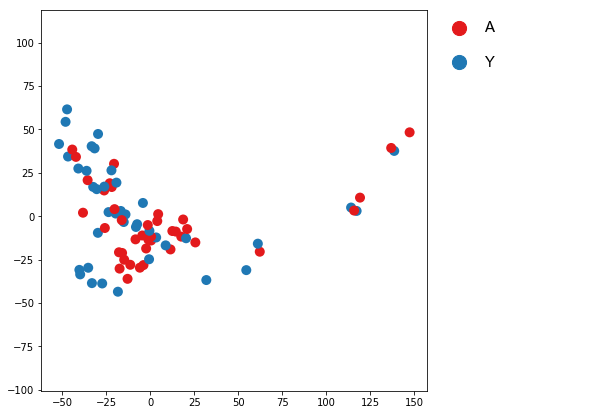

In [26]:
draw_scatter_groups(np.array(pcs)[:,(0,1)], 
                    M.loc['age'][pcs.index],
                    cmap = {'Y':'#1f78b4','A':'#e31a1c'},
                    s = 100,
                    pad = 10e0)

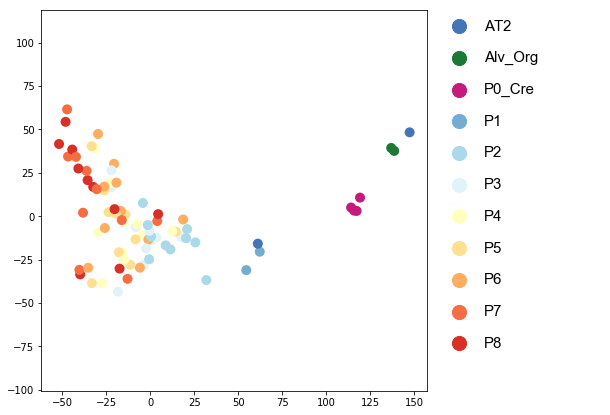

In [27]:
draw_scatter_groups(np.array(pcs)[:,(0,1)], 
                    M.loc['passage'][pcs.index],
                    cmap_conditions,
                    s = 100,
                    pad = 10e0, 
                    show_legend = True)

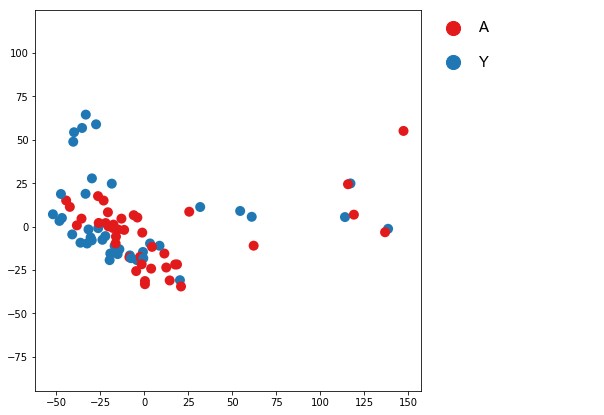

In [28]:
draw_scatter_groups(np.array(pcs)[:,(0,2)], 
                    M.loc['age'][pcs.index],
                    cmap = {'Y':'#1f78b4','A':'#e31a1c'},
                    s = 100,
                    pad = 10e0)

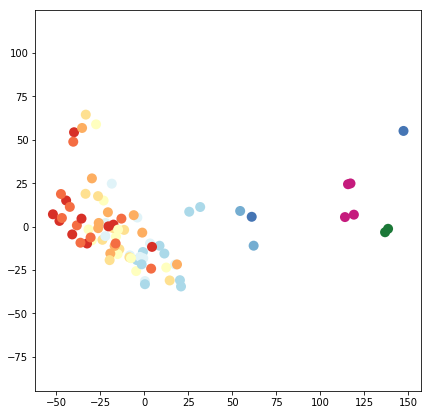

In [29]:
draw_scatter_groups(np.array(pcs)[:,(0,2)], 
                    M.loc['passage'][pcs.index],
                    cmap_conditions,
                    s = 100,
                    pad = 10e0,
                    show_legend = False)

Text(0.5, 0, 'PC3')

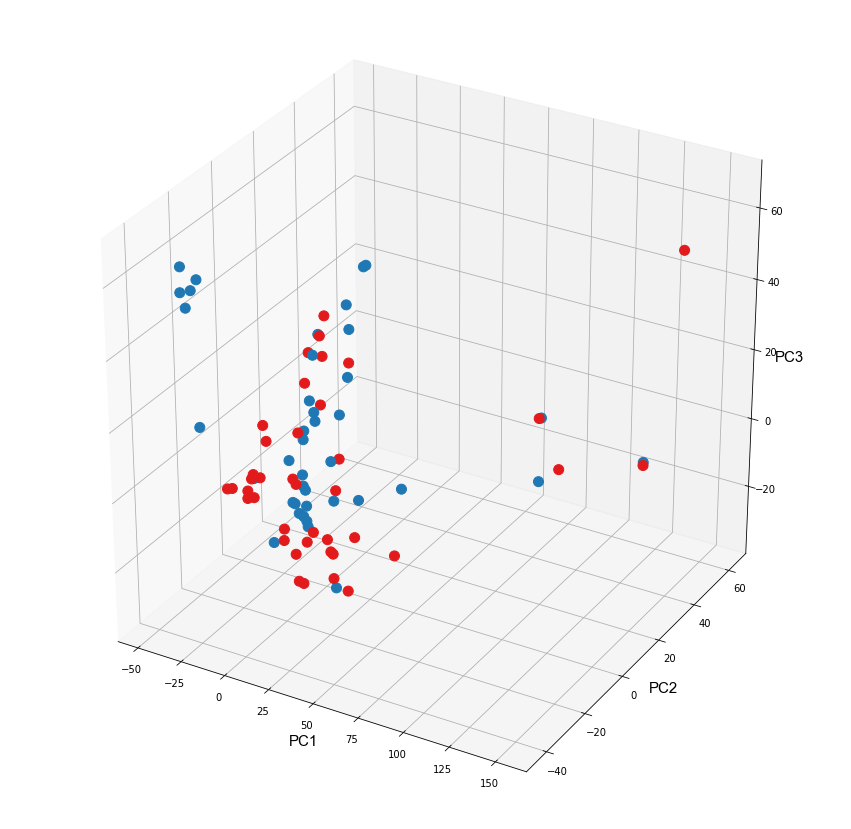

In [30]:
coords = np.array(pcs)[:,0:3]
groups = M.loc['age'][pcs.index]
cmap = {'Y':'#1f78b4','A':'#e31a1c'}


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

Text(0.5, 0, 'PC3')

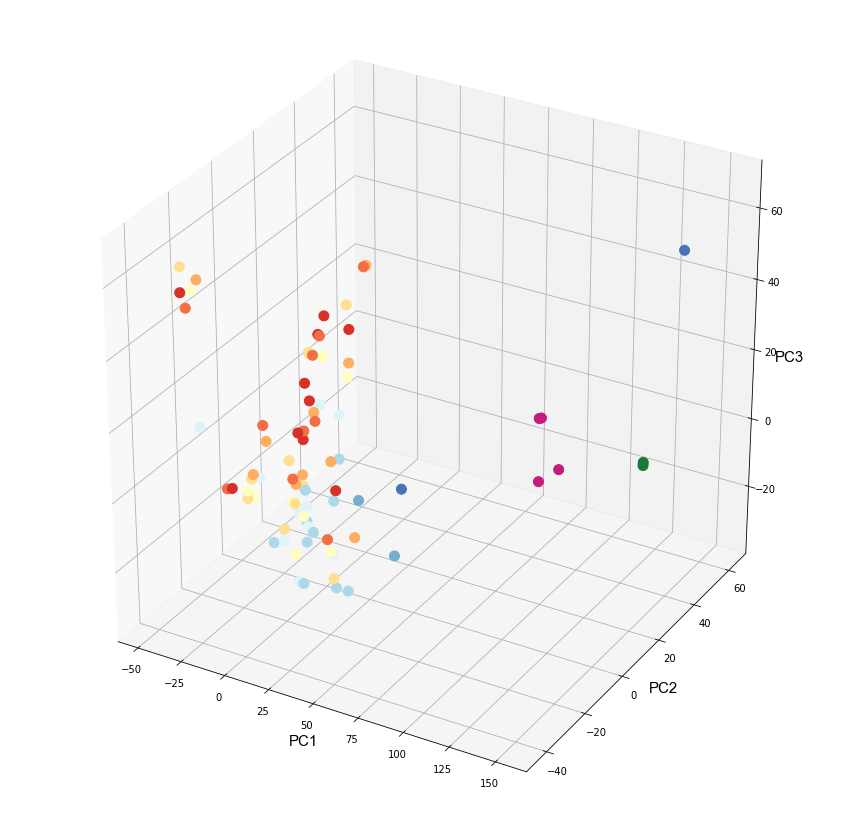

In [31]:
coords = np.array(pcs)[:,0:3]
groups = M.loc['passage'][pcs.index]
cmap = cmap_conditions


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

## NMF

In [32]:
from sklearn.decomposition import NMF

In [33]:
cmap_conditions = {'AT2':'#4575b4',
                   'P1':'#74add1',
                   'P2':'#abd9e9',
                   'P3':'#e0f3f8',
                   'P4':'#ffffbf',
                   'P5':'#fee090',
                   'P6':'#fdae61',
                   'P7':'#f46d43',
                   'P8':'#d73027',
                   'Alv_Org':'#1b7837',
                   'P0_Cre':'#c51b7d',}

In [34]:
nmf = NMF(n_components=5)
nmf = pd.DataFrame(nmf.fit_transform(Xs.T), index = Xs.columns, columns = range(5))

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


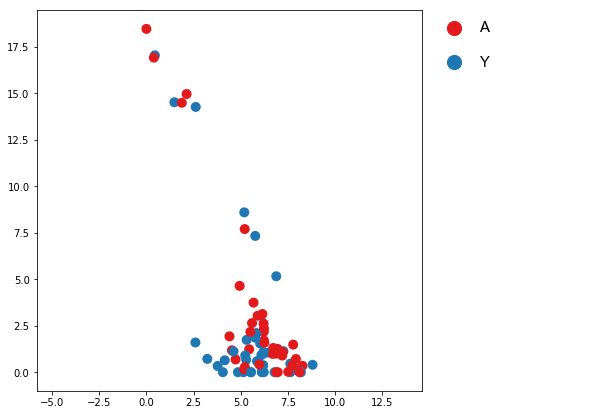

In [35]:
draw_scatter_groups(np.array(nmf)[:,(0,1)], 
                    M.loc['age'][nmf.index],
                    cmap = {'Y':'#1f78b4','A':'#e31a1c'},
                    s = 100,
                    pad = 1)

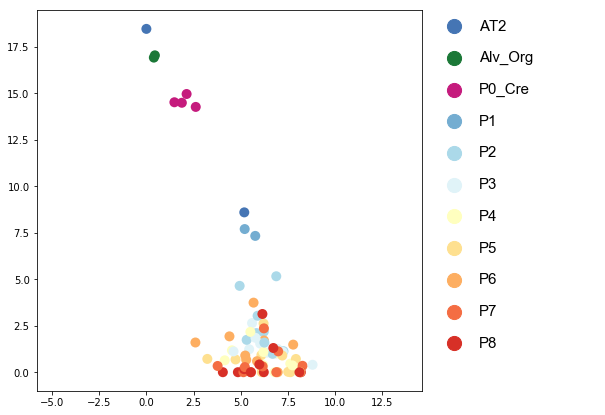

In [36]:
draw_scatter_groups(np.array(nmf)[:,(0,1)], 
                    M.loc['passage'][nmf.index],
                    cmap_conditions,
                    s = 100,
                    pad = 1, 
                    show_legend = True)

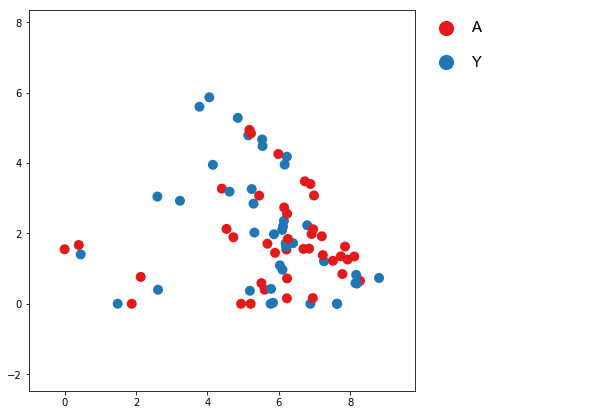

In [37]:
draw_scatter_groups(np.array(nmf)[:,(0,2)], 
                    M.loc['age'][nmf.index],
                    cmap = {'Y':'#1f78b4','A':'#e31a1c'},
                    s = 100,
                    pad = 1)

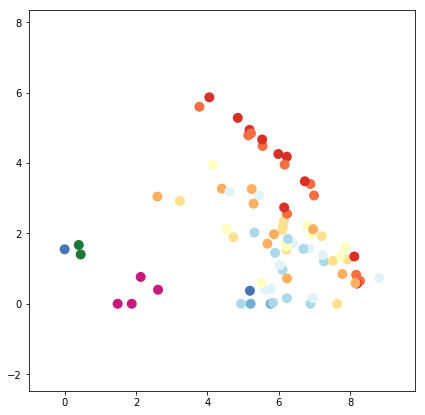

In [38]:
draw_scatter_groups(np.array(nmf)[:,(0,2)], 
                    M.loc['passage'][nmf.index],
                    cmap_conditions,
                    s = 100,
                    pad = 1,
                    show_legend = False)

Text(0.5, 0, 'PC3')

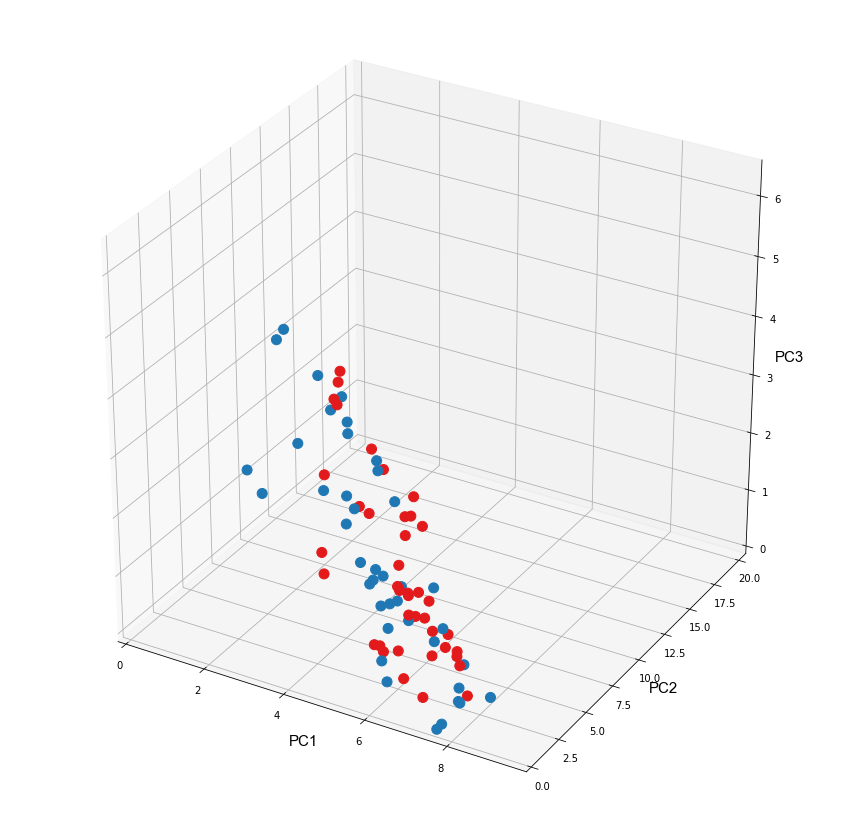

In [39]:
coords = np.array(nmf)[:,0:3]
groups = M.loc['age'][nmf.index]
cmap = {'Y':'#1f78b4','A':'#e31a1c'}


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

Text(0.5, 0, 'PC3')

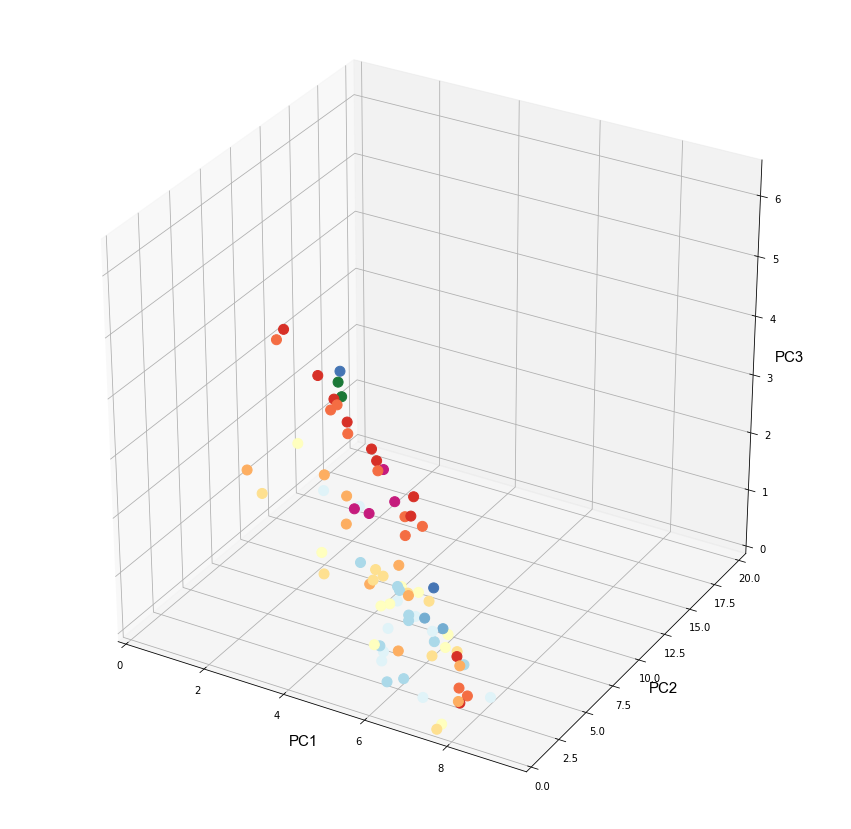

In [40]:
coords = np.array(nmf)[:,0:3]
groups = M.loc['passage'][nmf.index]
cmap = cmap_conditions


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 100)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

## Diffusion map

In [41]:
def pd2sc(df):
    
    X = df
    
    obs = pd.DataFrame(index = X.columns)
    
    var = pd.DataFrame(index = X.index)
    
    scdata = sc.AnnData(np.array(X.T), obs = obs, var = var)
    scdata.var_names_make_unique()
    scdata.obs_names_make_unique()

    return scdata

In [42]:
scX = pd2sc(Xs)
scX.obs = M.T

In [43]:
sc.tl.pca(scX, n_comps=50)

In [44]:
sc.pp.neighbors(scX, n_neighbors=10, n_pcs=50, method='gauss', use_rep='X_pca')

In [45]:
sc.tl.diffmap(scX, n_comps=4)

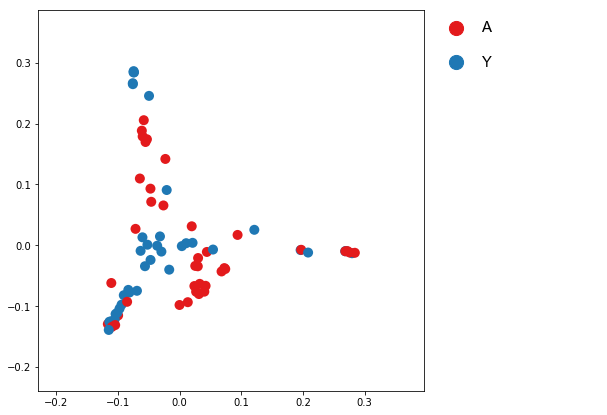

In [46]:
draw_scatter_groups(scX.obsm['X_diffmap'][:,(1,2)], 
                    M.loc['age'][scX.obs_names],
                    cmap = {'Y':'#1f78b4','A':'#e31a1c'},
                    s = 100,
                    pad = 0.1)

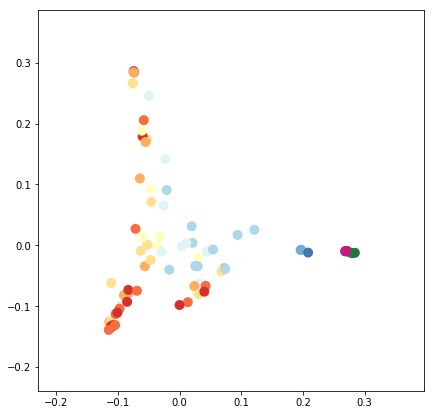

In [47]:
draw_scatter_groups(scX.obsm['X_diffmap'][:,(1,2)], 
                    M.loc['passage'][scX.obs_names],
                    cmap = cmap_conditions,
                    s = 100,
                    pad = 0.1, show_legend=False)

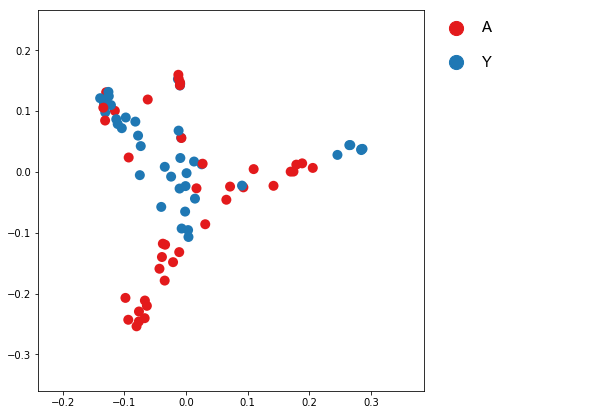

In [48]:
draw_scatter_groups(scX.obsm['X_diffmap'][:,(2,3)], 
                    M.loc['age'][scX.obs_names],
                    cmap = {'Y':'#1f78b4','A':'#e31a1c'},
                    s = 100,
                    pad = 0.1)

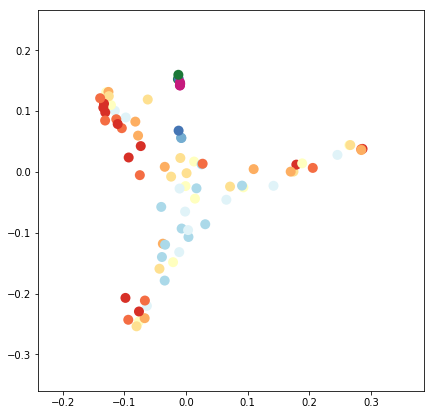

In [49]:
draw_scatter_groups(scX.obsm['X_diffmap'][:,(2,3)], 
                    M.loc['passage'][scX.obs_names],
                    cmap = cmap_conditions,
                    s = 100,
                    pad = 0.1, show_legend=False)

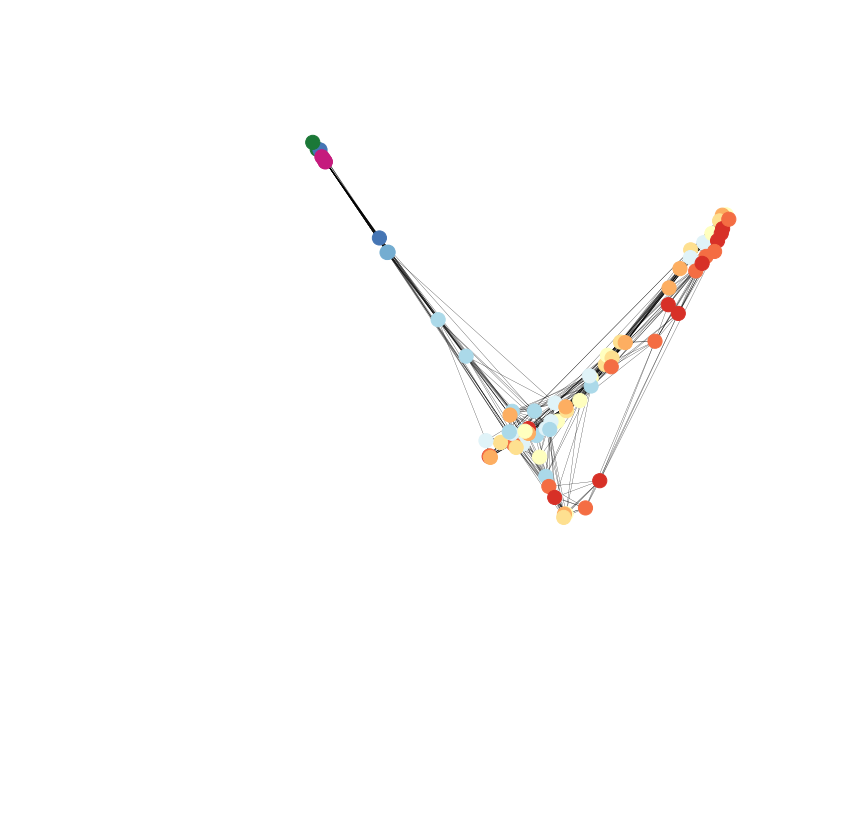

In [276]:
dat = scX
coords = dat.obsm['X_diffmap'][:,1:]
groups = M.loc['passage'][dat.obs_names]
cmap = cmap_conditions


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[cmap[i] for i in groups],
           alpha=1,
           s = 200)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

conn = dat.obsp['connectivities'].todense()
for p,q in itertools.combinations(range(len(dat.obs_names)),2):
    if conn[p,q]:
        ax.plot(coords[(p,q),0], coords[(p,q),1], coords[(p,q),2], c='k', lw=0.25)
        
ax.set_axis_off()
        
figname = 'invitro_scatter_stage.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Get diffusion pseudotime

In [255]:
scX.uns['iroot'] = np.flatnonzero(scX.obs['passage']=='AT2')[0]

In [256]:
sc.tl.dpt(scX, n_dcs=3, n_branchings=0)

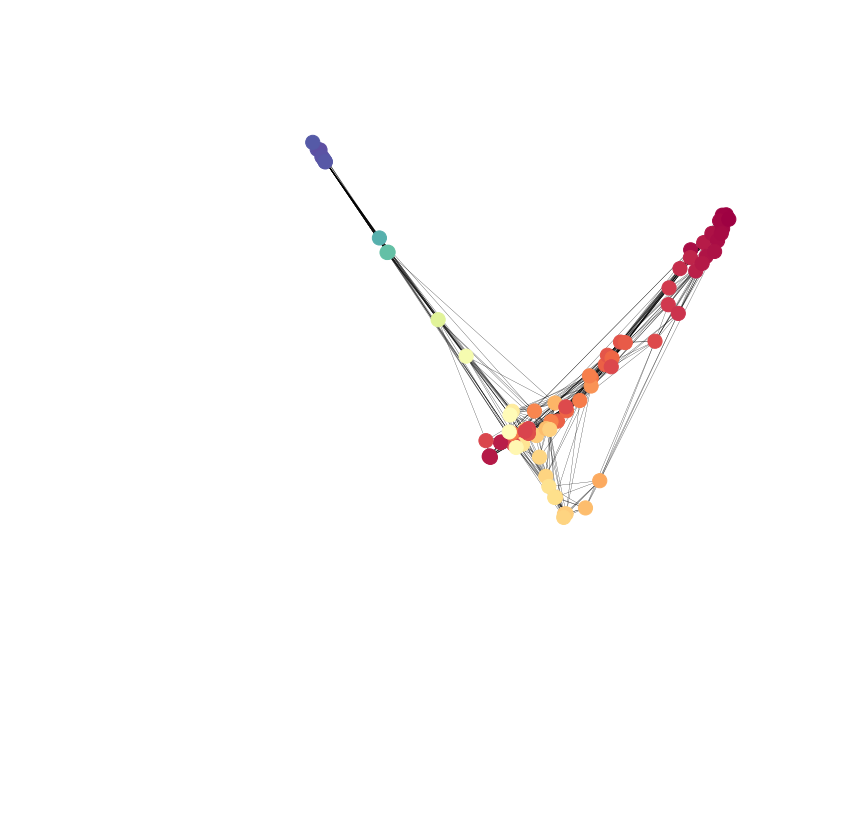

In [278]:
dat = scX
coords = dat.obsm['X_diffmap'][:,1:]

height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[plt.cm.Spectral_r(i) for i in dat.obs['dpt_pseudotime']],
           alpha=1,
           s = 200)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

conn = dat.obsp['connectivities'].todense()
for p,q in itertools.combinations(range(len(dat.obs_names)),2):
    if conn[p,q]:
        ax.plot(coords[(p,q),0], coords[(p,q),1], coords[(p,q),2], c='k', lw=0.25)
        
ax.set_axis_off()
        
figname = 'invitro_scatter_dpt.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Place cells along pseudotime

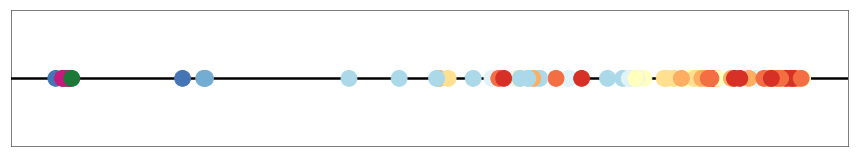

In [258]:
dat = scX.obs['dpt_pseudotime']
groups = scX.obs['passage']
cmap = cmap_conditions

height = 2.5
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111)

ax.axhline(0.5, linewidth=2.5, color='k', zorder=0)

ax.scatter(dat,
           [0.5] * len(dat),
           c = [cmap[i] for i in groups],
           s=250)

remove_ticks(ax)

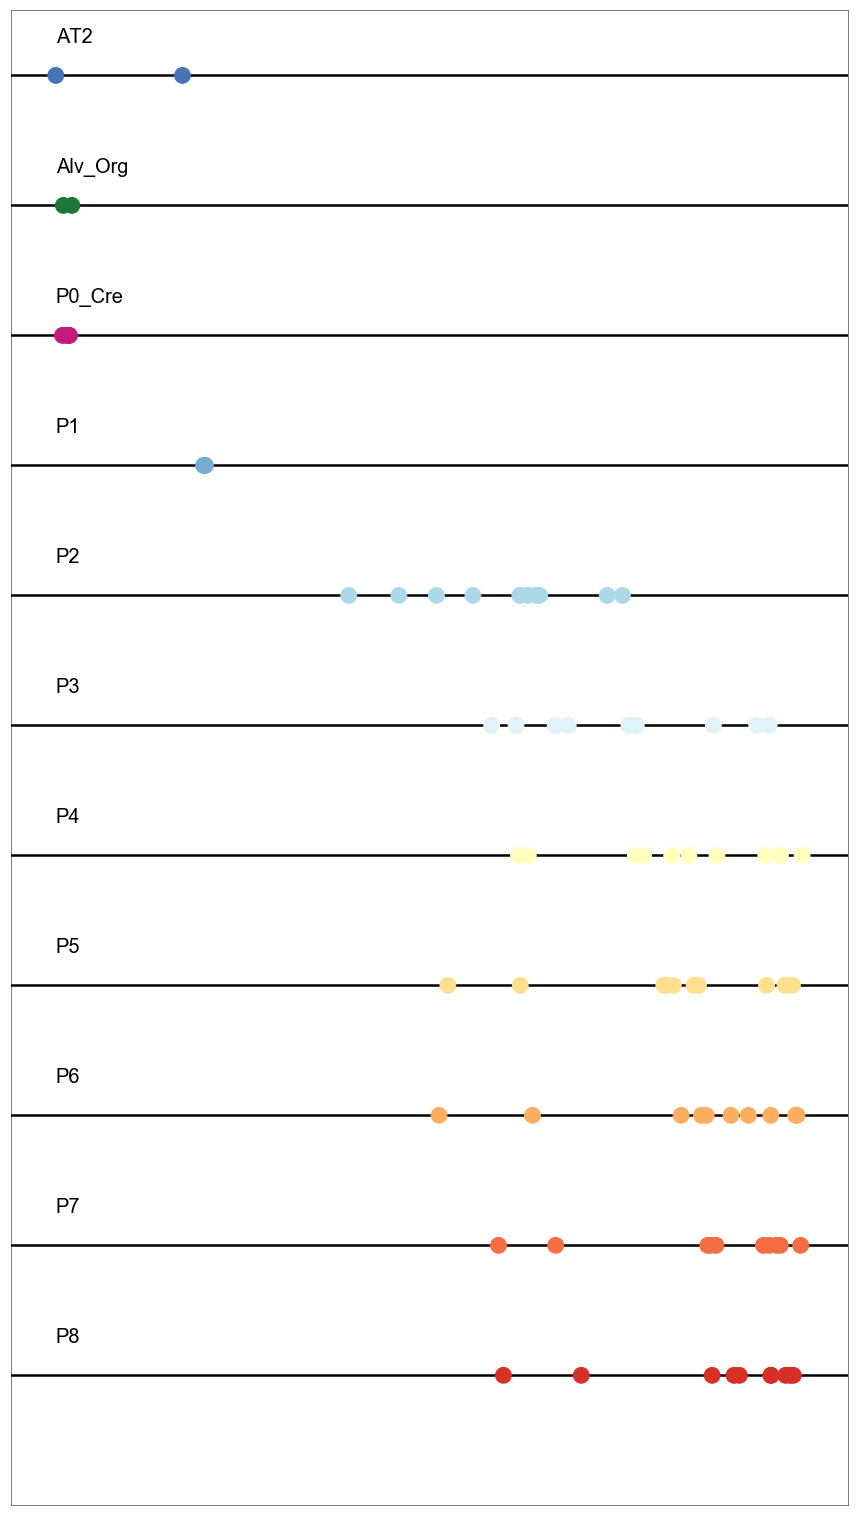

In [259]:
dat = scX.obs['dpt_pseudotime']
groups = scX.obs['passage']
gr_order = ['AT2',
            'Alv_Org',
            'P0_Cre',
            'P1',
            'P2',
            'P3',
            'P4',
            'P5',
            'P6',
            'P7',
            'P8',]
cmap = cmap_conditions

height = 2.5 * len(gr_order)
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111)

ax.set_ylim(len(gr_order), -0.5)

for p, gr in enumerate(gr_order):
    ax.axhline(p, linewidth=2.5, color='k', zorder=0)
    i_sel = groups[groups==gr].index 
    ax.scatter(dat[i_sel],
               [p] * len(i_sel),
               c = [cmap[i] for i in groups[i_sel]],
               s=250)
    
    ax.text(0, p-0.25, gr, family='Arial', fontsize=20)

remove_ticks(ax)

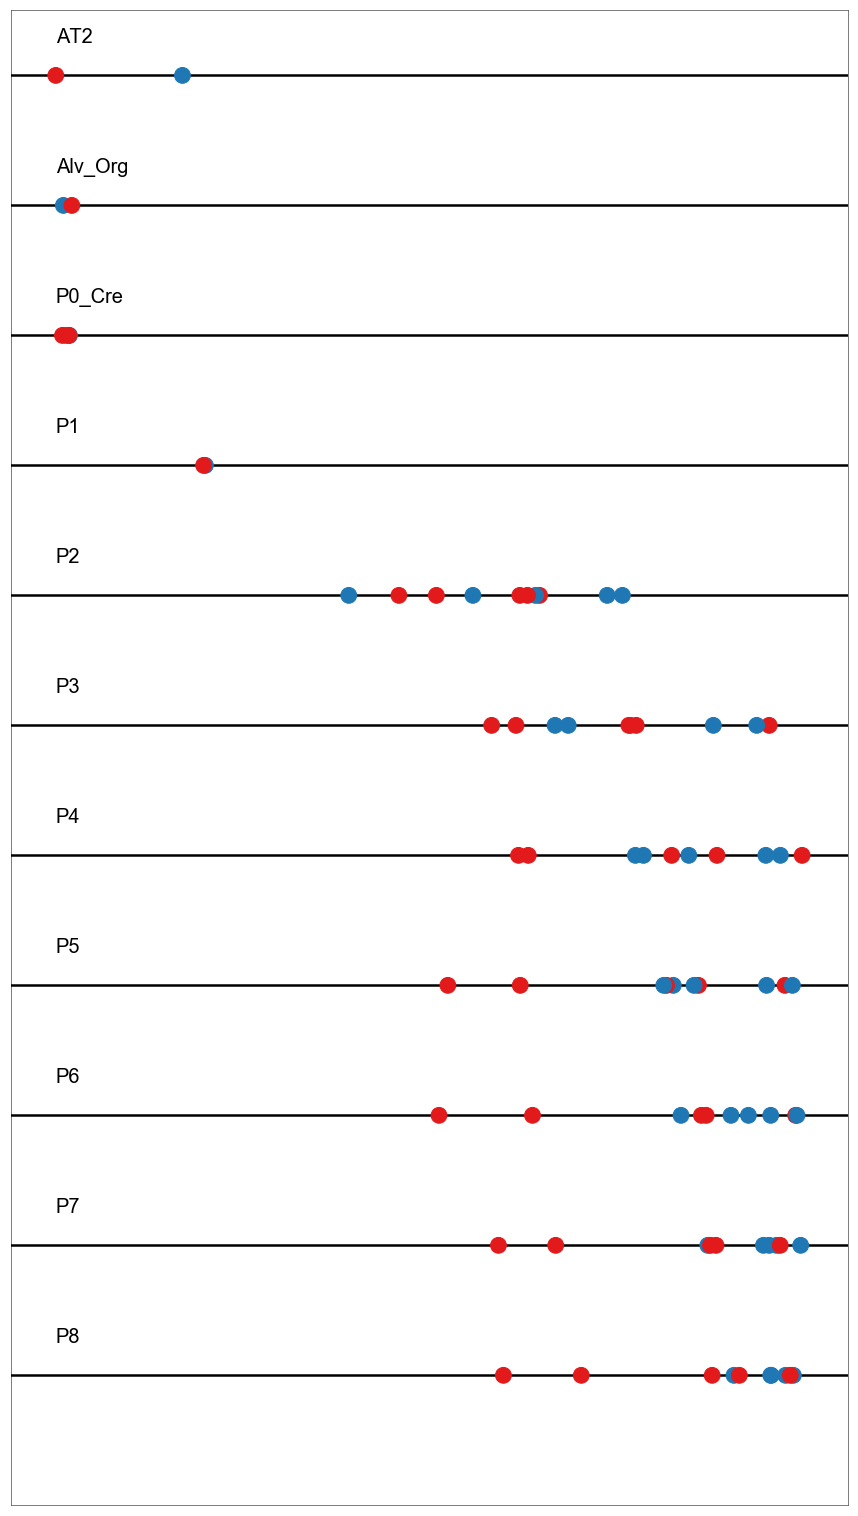

In [260]:
dat = scX.obs['dpt_pseudotime']
groups = scX.obs['passage']
gr_order = ['AT2',
            'Alv_Org',
            'P0_Cre',
            'P1',
            'P2',
            'P3',
            'P4',
            'P5',
            'P6',
            'P7',
            'P8',]
cmap = {'Y':'#1f78b4','A':'#e31a1c'}

height = 2.5 * len(gr_order)
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111)

ax.set_ylim(len(gr_order), -0.5)

for p, gr in enumerate(gr_order):
    ax.axhline(p, linewidth=2.5, color='k', zorder=0)
    i_sel = groups[groups==gr].index 
    ax.scatter(dat[i_sel],
               [p] * len(i_sel),
               c = [cmap[i] for i in scX.obs['age'][i_sel]],
               s=250)
    
    ax.text(0, p-0.25, gr, family='Arial', fontsize=20)

remove_ticks(ax)

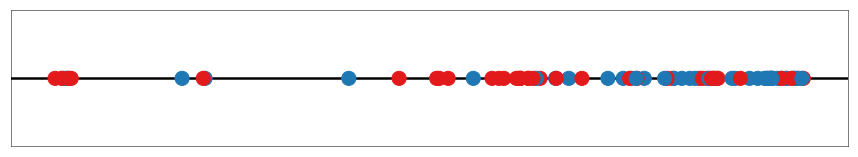

In [261]:
dat = scX.obs['dpt_pseudotime']
groups = scX.obs['age']
cmap = {'Y':'#1f78b4','A':'#e31a1c'}

height = 2.5
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111)

ax.axhline(0.5, linewidth=2.5, color='k', zorder=0)

ax.scatter(dat,
           [0.5] * len(dat),
           c = [cmap[i] for i in groups],
           s=200)

remove_ticks(ax)

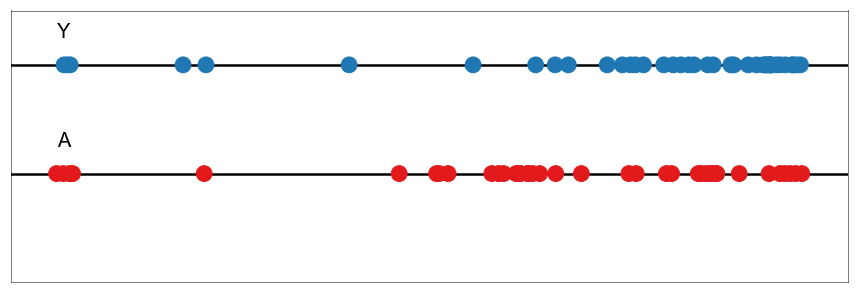

In [262]:
dat = scX.obs['dpt_pseudotime']
groups = scX.obs['age']
gr_order = ['Y','A']
cmap = {'Y':'#1f78b4','A':'#e31a1c'}

height = 2.5 * len(gr_order)
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111)

ax.set_ylim(len(gr_order), -0.5)

for p, gr in enumerate(gr_order):
    ax.axhline(p, linewidth=2.5, color='k', zorder=0)
    i_sel = groups[groups==gr].index 
    ax.scatter(dat[i_sel],
               [p] * len(i_sel),
               c = [cmap[i] for i in groups[i_sel]],
               s=250)
    
    ax.text(0, p-0.25, gr, family='Arial', fontsize=20)

remove_ticks(ax)

In [263]:
c_sel_A = scX.obs['age'][scX.obs['age']=='A'].index
c_sel_Y = scX.obs['age'][scX.obs['age']=='Y'].index
scipy.stats.mannwhitneyu(scX.obs['dpt_pseudotime'][c_sel_A], scX.obs['dpt_pseudotime'][c_sel_Y])

MannwhitneyuResult(statistic=570.0, pvalue=0.01360942745742276)

## Difference in pseudotime at time of passage

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


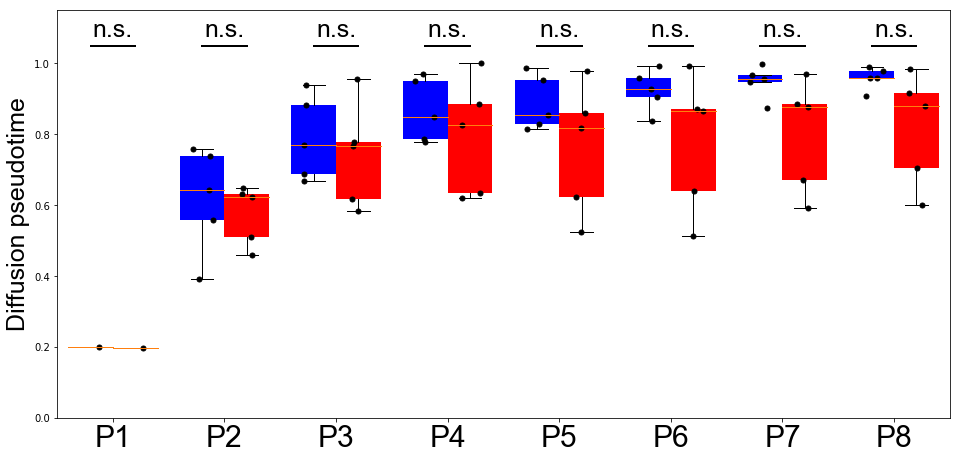

In [279]:
dat = scX.obs['dpt_pseudotime']
groups = scX.obs['passage']
gr_order = ['P1','P2','P3','P4','P5','P6','P7','P8',]
l = len(gr_order)

plt.figure(facecolor = 'w', figsize = (l*2, 7.5))

ax = plt.subplot(111)

ax.set_ylabel('Diffusion pseudotime', family = 'Arial', fontsize = 25)

dat_y = []
dat_a = []
pvals = []

for p, i in enumerate(gr_order):
    ix = scX.obs['passage'][scX.obs['passage']==i].index
    ix_y = scX.obs['age'][ix][scX.obs['age'][ix]=='Y'].index
    ix_a = scX.obs['age'][ix][scX.obs['age'][ix]=='A'].index
    dat_y.append(dat[ix_y].values)
    dat_a.append(dat[ix_a].values)
    pvals.append(scipy.stats.mannwhitneyu(dat[ix_y].values, dat[ix_a])[1])

box_y = ax.boxplot(x=dat_y,
                   positions = [i*2-0.4 for i in range(l)], 
                   vert=True, 
                   notch=False, 
                   patch_artist=True, 
                   showfliers=False,
                   widths=0.8,
                   zorder = 1)

for p,b in enumerate(box_y['boxes']):
    b.set_facecolor('blue')
    b.set_linewidth(0.0)
    b.set_zorder(0)
    
box_a = ax.boxplot(x=dat_a,
                   positions = [i*2+0.4 for i in range(l)], 
                   vert=True, 
                   notch=False, 
                   patch_artist=True, 
                   showfliers=False,
                   widths=0.8,
                   zorder = 1)

for p,b in enumerate(box_a['boxes']):
    b.set_facecolor('red')
    b.set_linewidth(0.0)
    b.set_zorder(0)
    
for p, i in enumerate(gr_order):
    
    ax.scatter(p*2-0.2-(np.random.random(len(dat_y[p])))*0.4,
               dat_y[p],
               c = 'k',
               s = 25,
               zorder = 1)
    ax.scatter(p*2+0.2+(np.random.random(len(dat_a[p])))*0.4,
               dat_a[p],
               c = 'k',
               s = 25,
               zorder = 1)
    
    ax.plot([p*2-0.4, p*2+0.4], [1.05,1.05], lw=2, color='k')
    pv = pvals[p]
    txt = 'n.s.'
    if pv < 0.05: txt = '*'
    if pv < 0.005: txt = '**'
    if pv < 0.001: txt = '***'
    ax.text(p*2, 1.075, txt, family='Arial', fontsize=25, ha='center')
    
ax.set_xlim(-1, l*2-1)
ax.set_xticks([i*2 for i in range(l)])
ax.set_xticklabels(gr_order, family='Arial', fontsize=30)

ax.set_ylim(0, 1.15)
        
figname = 'invitro_bar_dpt.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Checkpoint

In [220]:
#scX.write_h5ad('%s/%s_scX_12128_exvivo_transformation.h5' % (path_output, exp_id))

## In vivo LUAD cell populations

In [13]:
def sc2pd(scdata, layer, sparse=True):

    if sparse:
    
        if layer=='X':
            return pd.DataFrame(scdata.X.T.todense(),
                                index = scdata.var_names,
                                columns = scdata.obs_names)
        else:
            return pd.DataFrame(scdata.layers[layer].T.todense(),
                                index = scdata.var_names,
                                columns = scdata.obs_names)

    else:
    
        if layer=='X':
            return pd.DataFrame(scdata.X.T,
                                index = scdata.var_names,
                                columns = scdata.obs_names)
        else:
            return pd.DataFrame(scdata.layers[layer].T,
                                index = scdata.var_names,
                                columns = scdata.obs_names)

In [14]:
cmap_epithelial_tumor = {'AT2-like': '#b2df8a',
                         'AT2': '#33a02c',
                         'High plasticity cell state': '#a50f15',
                         'AT1-like': '#fb6a4a',
                         'Ribosome high': '#c51b7d',
                         'Endoderm-like': '#542788',
                         'AT1': '#e6ab02',
                         'Ciliated':'#666666', 
                         'Other':'silver'}

In [15]:
X = sc.read_h5ad('%s/%s_X_LUAD_aging_pp.h5' % ('/Users/simjoo/Projects/10X_aging/data_output/v3/', '202111251525'))

In [16]:
Xs = sc.read_h5ad('%s/%s_Xs_LUAD_aging_KP_tumor_subsampled.h5' % ('/Users/simjoo/Projects/10X_aging/data_output/v3/', '202111251525'))

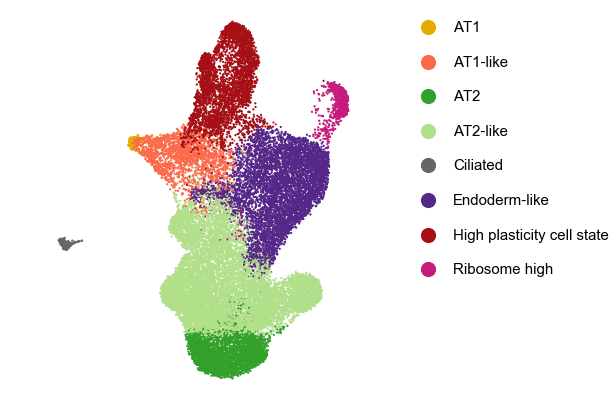

In [189]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['cl_epithelial_tumor_pca'],
                    cmap_epithelial_tumor,
                    s=5, show_axes=False)

In [190]:
pdX_mwu = sc2pd(Xs, 'norm_log2')

In [191]:
MWU_av_tumor_leiden = mwu_vs_average(pdX_mwu, Xs.obs['cl_epithelial_tumor_pca'], pdX_mwu.index, dview)

/Users/simjoo/Projects/aging_bulk_RNAseq/scripts/TenX_aging_mann_whitney_u_v1_0.py:82: RuntimeWarning: divide by zero encountered in log10
  output = -np.log10(output.astype(float))


In [192]:
MWU_gr_tumor_leiden = mwu_vs_groups(pdX_mwu, Xs.obs['cl_epithelial_tumor_pca'], pdX_mwu.index, dview)

In [193]:
degs_gr = {}

for gr in MWU_av_tumor_leiden.columns:
    degs_gr[gr] = list(MWU_av_tumor_leiden[gr][MWU_av_tumor_leiden[gr]>10].index)
    print(gr, len(degs_gr[gr]))

AT2 1003
AT2-like 864
AT1 347
High plasticity cell state 741
Endoderm-like 875
Ciliated 320
Ribosome high 148
AT1-like 329


In [12]:
X = load_from_txt(path_output, exp_id, 'X_12128_exvivo_transformation_raw', 'DataFrame')
M = load_from_txt(path_output, exp_id, 'M_12128_exvivo_transformation', 'DataFrame')

In [13]:
from sklearn.preprocessing import MaxAbsScaler

## Filter unexpressed genes

In [14]:
X = filter_nonexpressed(X)

31017 genes in dataset
After removing non-expressed genes, 29891 genes remain


In [15]:
X

,AF1338_P4,GH1397_P4,AF1181_P5,GH2108_P3,GH1493_P5,AF1337_P4,AF1337_P0_Cre,GH2108_P6,AF1165_P0_Cre,AF1183_P4,...,KW1401_P8,GH1397_P8,AF1165_P7,GH1394_P7,AF1337_P7,GH2108_P8,GH1394_P8,GH2108_P7,AF1337_P8,AF1183_P7
0,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0,0,9,0,1,0,0,3,0,6,...,5,1,3,6,0,0,0,0,0,1
0610006L08Rik,0,1,1,1,0,0,0,7,0,7,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,286,132,132,153,195,168,174,127,164,140,...,248,261,308,300,244,319,292,319,404,243
0610009O20Rik,37,43,39,25,43,32,58,38,63,50,...,74,69,94,105,77,76,102,87,90,88
0610010F05Rik,116,156,248,160,272,329,176,121,36,228,...,217,266,447,285,492,339,190,327,666,498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Nd3,3,3,2,13,2,5,2,17,1,8,...,13,6,10,2,7,6,10,6,9,7
mt-Nd4,3203,863,2185,2004,2646,1966,2539,2695,2906,1584,...,3227,2479,3964,2487,4270,2900,2530,3873,4420,4600
mt-Nd4l,5,0,0,2,1,1,3,3,1,4,...,3,1,3,2,1,2,2,2,1,6


## Size factor normalisation in DESeq2

In [15]:
mat_to_DESEq2 = X
classes_to_DESeq2 = M.T

In [16]:
%%R -i mat_to_DESEq2 -i classes_to_DESeq2 -o cnts_DESeq2

dds <- DESeqDataSetFromMatrix(countData = mat_to_DESEq2, colData = classes_to_DESeq2, design=~1)
dds <- estimateSizeFactors(dds) 
cnts <- counts(dds, normalized=TRUE)
cnts_DESeq2 <- as.data.frame(cnts)

In [17]:
Xs = np.log2(cnts_DESeq2+1)
#Xs = cnts_DESeq2

## Get scores

In [200]:
X_maxabs = pd.DataFrame(MaxAbsScaler().fit_transform(Xs.T).T, index = Xs.index, columns=Xs.columns)

In [201]:
X_pop = pd.DataFrame(index = degs_gr.keys(), columns = X_maxabs.columns)

for i in degs_gr.keys():
    g_sel = [i for i in degs_gr[i] if i in X_maxabs.index]
    X_pop.loc[i] = X_maxabs.loc[g_sel].sum()

In [202]:
gr_order = []

for p in ['AT2', 'Alv_Org', 'P0_Cre', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']:
    for a in ['Y','A']:
        gr_order += list(M.loc['age'][(M.loc['age']==a)&(M.loc['passage']==p)].index)

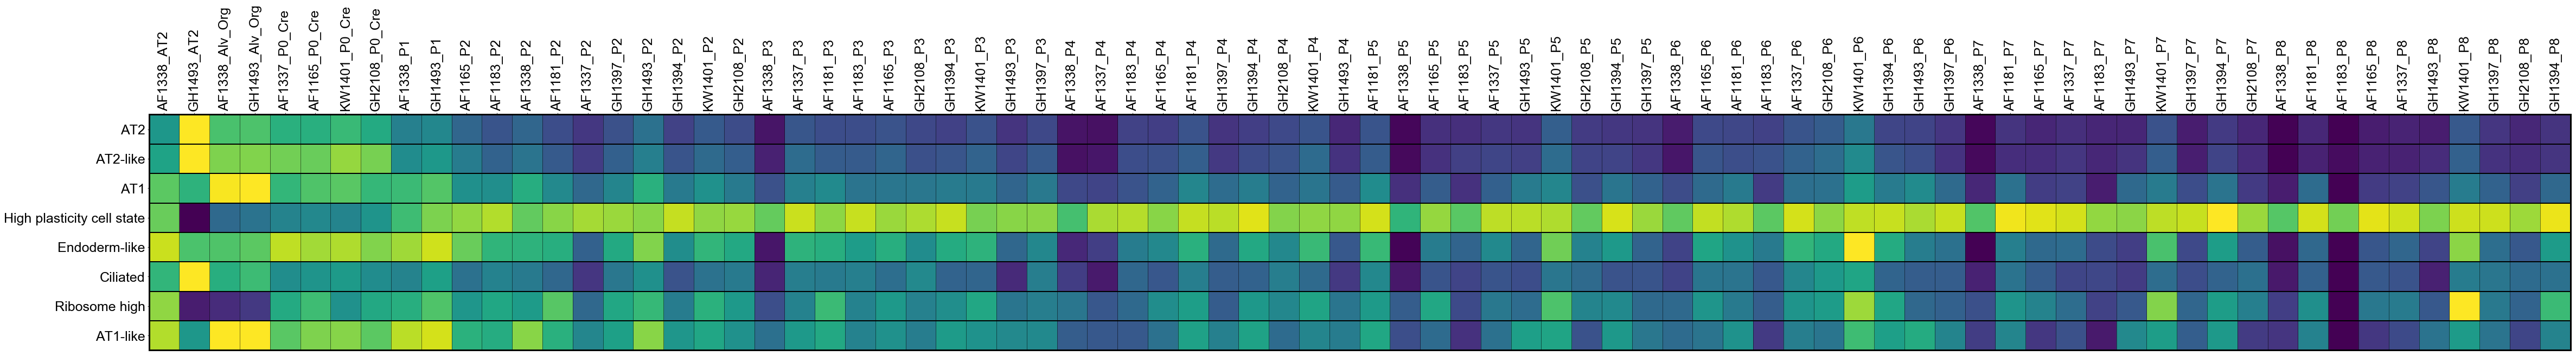

In [203]:
features = degs_gr.keys()
groups = gr_order
dat = X_pop.loc[features, groups]
dat = dat.apply(lambda x: (x-np.min(x)) / (np.max(x)-np.min(x)), axis=1)
#dat = np.log2(dat.loc[features].astype(float)+1)
#dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = 0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

## Get combined scores

In [19]:
X_pop_comb = pd.DataFrame(index=X_pop.index)
gr_order = []

for p in ['AT2', 'Alv_Org', 'P0_Cre', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']:
    for a in ['Y','A']:
        gr_sel = list(M.loc['age'][(M.loc['age']==a)&(M.loc['passage']==p)].index)
        X_pop_comb['%s_%s'%(p,a)] = X_pop[gr_sel].mean(axis=1)

NameError: name 'X_pop' is not defined

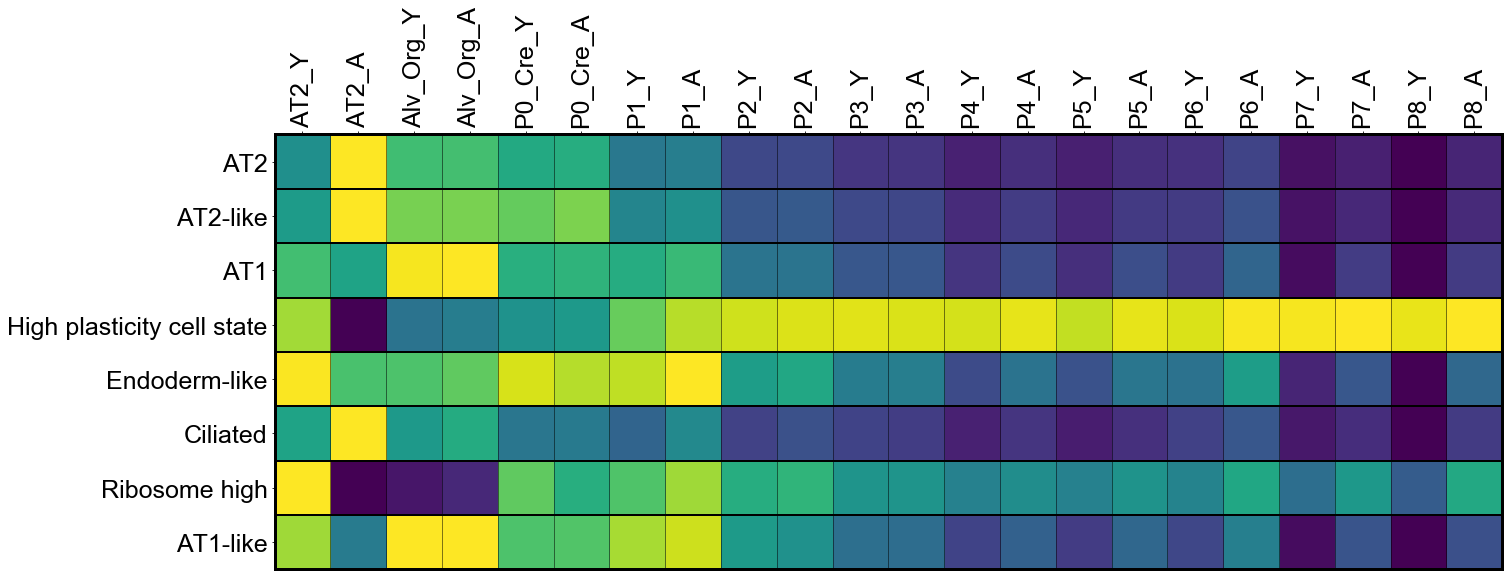

In [205]:
features = degs_gr.keys()
groups = X_pop_comb.columns
dat = X_pop_comb.loc[features, groups]
dat = dat.apply(lambda x: (x-np.min(x)) / (np.max(x)-np.min(x)), axis=1)
#dat = np.log2(dat.loc[features].astype(float)+1)
#dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = 0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

## Look at individual genes

In [19]:
gr_order = []

for p in ['AT2', 'Alv_Org', 'P0_Cre', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']:
    for a in ['Y','A']:
        gr_order += list(M.loc['age'][(M.loc['age']==a)&(M.loc['passage']==p)].index)

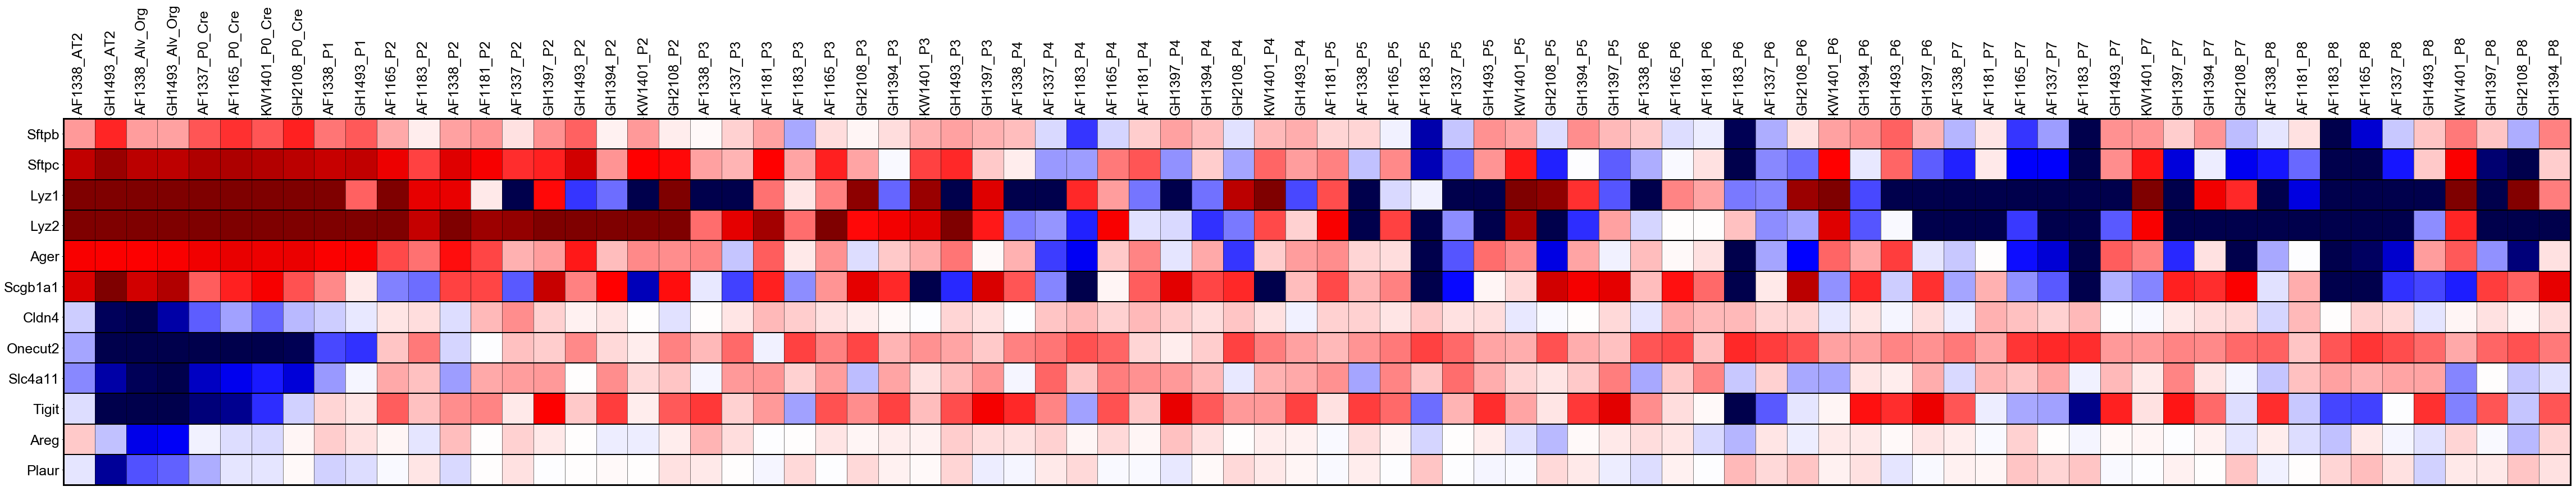

In [207]:
features = ['Sftpb','Sftpc','Lyz1','Lyz2','Ager','Scgb1a1',
            'Cldn4','Onecut2','Slc4a11','Tigit','Areg','Plaur']
groups = gr_order
dat = Xs.loc[features, groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 0.5, color = 'k')

In [18]:
Xs_comb = pd.DataFrame(index=Xs.index)
gr_order = []

for p in ['AT2', 'Alv_Org', 'P0_Cre', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8']:
    for a in ['Y','A']:
        gr_sel = list(M.loc['age'][(M.loc['age']==a)&(M.loc['passage']==p)].index)
        Xs_comb['%s_%s'%(p,a)] = Xs[gr_sel].mean(axis=1)

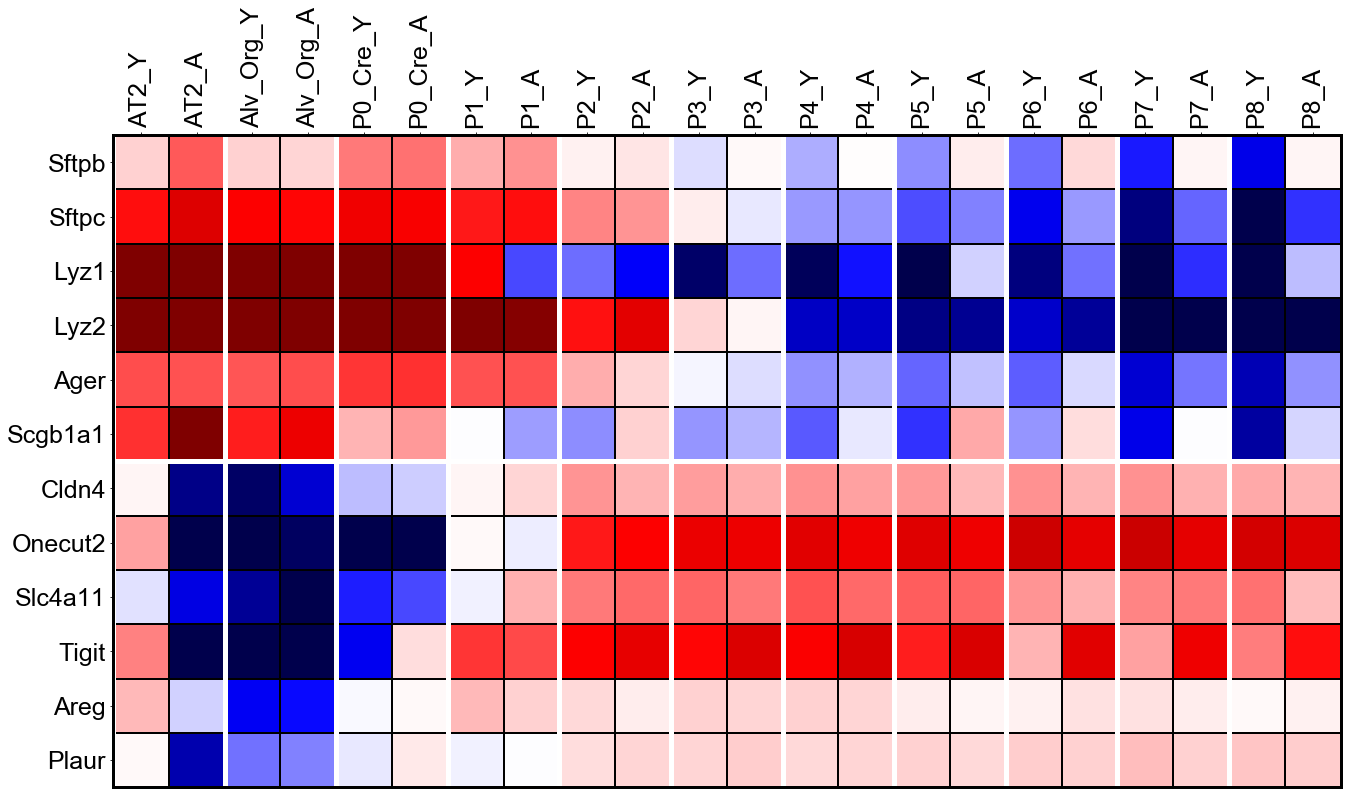

In [295]:
features = ['Sftpb','Sftpc','Lyz1','Lyz2','Ager','Scgb1a1',
            'Cldn4','Onecut2','Slc4a11','Tigit','Areg','Plaur']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))

ax = plt.subplot(111)
    
#plot data

ax.imshow(dat.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 25, family = 'Arial')

#plot group names

ax.set_xticks(range(len(groups)))
ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2 - 0.5, linewidth = 5, color = 'w')
    
ax.axhline(5+0.5, linewidth = 5, color = 'w')

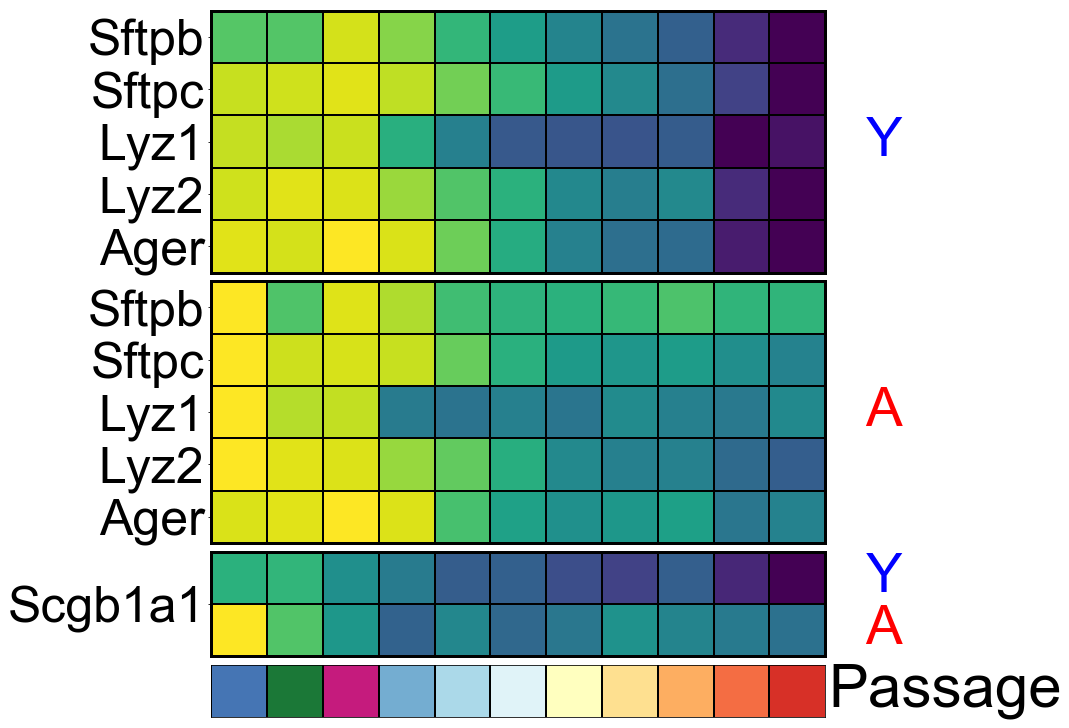

In [20]:
features = ['Sftpb','Sftpc','Lyz1','Lyz2','Ager','Scgb1a1']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat.loc[features]+1)
dat = dat.apply(lambda x: (x-x.min()) / (x.max()-x.min()), axis=1)

#rearrange data

ixs = []
for a in ['Y','A']:
    for f in features:
        ixs.append('%s_%s'%(f,a))
dat2 = pd.DataFrame(index = ixs,
                    columns = ['AT2','Alv_Org','P0_Cre','P1','P2','P3','P4','P5','P6','P7','P8'])
for gr in dat2.columns:
    for a in ['Y','A']:
        for f in features:
            dat2.loc['%s_%s'%(f,a)][gr] = dat.loc[f]['%s_%s'%(gr,a)]
    
#initialize figure

height = 1 * len(dat2.index)+1
width = 1 * len(dat2.columns)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(4, 1, hspace=0.05, height_ratios=[len(features)-1, len(features)-1, 2,1])
    
#plot data - young 

ax = plt.subplot(gs[0])

ax.set_xticks([])

ixs = ['%s_Y' % i for i in features[:-1]]
ax.imshow(dat2.loc[ixs].astype(float), vmin = -0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)-1))
ax.set_yticklabels([i.split('_')[0] for i in features[:-1]], fontsize = 50, family = 'Arial')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)-1):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
#plot age labels

ax.text(len(dat2.columns)*1.05, (len(features)-1)/2-0.5, 'Y', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='blue')

#plot data - aged

ax = plt.subplot(gs[1])

ax.set_xticks([])

ixs = ['%s_A' % i for i in features[:-1]]
ax.imshow(dat2.loc[ixs].astype(float), vmin = -0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)-1))
ax.set_yticklabels([i.split('_')[0] for i in features[:-1]], fontsize = 50, family = 'Arial')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)-1):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
#plot age labels

ax.text(len(dat2.columns)*1.05, (len(features)-1)/2-0.5, 'A', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='red')

#Scgb1a1 expression

ax = plt.subplot(gs[2])

ax.set_xticks([])

ixs = ['Scgb1a1_Y','Scgb1a1_A']
ax.imshow(dat2.loc[ixs].astype(float), vmin = -0, vmax = 1, cmap = plt.cm.viridis, aspect = 'auto')

ax.set_yticks([0.5])
ax.set_yticklabels(['Scgb1a1'], fontsize = 50, family = 'Arial')
              
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(2):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
ax.text(len(dat2.columns)*1.05, 0, 'Y', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='blue')
ax.text(len(dat2.columns)*1.05, 1, 'A', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='red')

#passage
            
ax = plt.subplot(gs[3])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color=cmap_conditions['_'.join(p.split('_')[:-1])])
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 2, color = 'k')
    
ax.set_xticks([])
ax.set_yticks([])
    
ax.text(len(groups)*1.005, 0.5, 'Passage', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')

figname = 'invitro_heatmap4_viridis.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

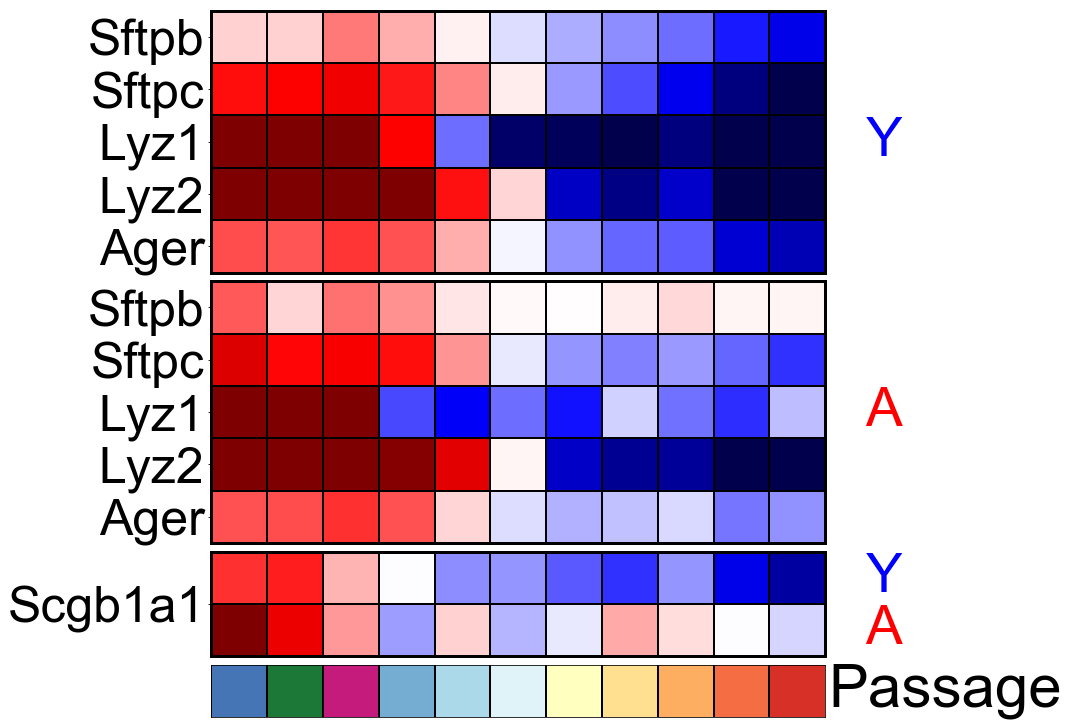

In [30]:
features = ['Sftpb','Sftpc','Lyz1','Lyz2','Ager','Scgb1a1']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)

#rearrange data

ixs = []
for a in ['Y','A']:
    for f in features:
        ixs.append('%s_%s'%(f,a))
dat2 = pd.DataFrame(index = ixs,
                    columns = ['AT2','Alv_Org','P0_Cre','P1','P2','P3','P4','P5','P6','P7','P8'])
for gr in dat2.columns:
    for a in ['Y','A']:
        for f in features:
            dat2.loc['%s_%s'%(f,a)][gr] = dat.loc[f]['%s_%s'%(gr,a)]
    
#initialize figure

height = 1 * len(dat2.index)+1
width = 1 * len(dat2.columns)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(4, 1, hspace=0.05, height_ratios=[len(features)-1, len(features)-1, 2,1])
    
#plot data - young 

ax = plt.subplot(gs[0])

ax.set_xticks([])

ixs = ['%s_Y' % i for i in features[:-1]]
ax.imshow(dat2.loc[ixs].astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)-1))
ax.set_yticklabels([i.split('_')[0] for i in features[:-1]], fontsize = 50, family = 'Arial')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)-1):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
#plot age labels

ax.text(len(dat2.columns)*1.05, (len(features)-1)/2-0.5, 'Y', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='blue')

#plot data - aged

ax = plt.subplot(gs[1])

ax.set_xticks([])

ixs = ['%s_A' % i for i in features[:-1]]
ax.imshow(dat2.loc[ixs].astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)-1))
ax.set_yticklabels([i.split('_')[0] for i in features[:-1]], fontsize = 50, family = 'Arial')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)-1):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
#plot age labels

ax.text(len(dat2.columns)*1.05, (len(features)-1)/2-0.5, 'A', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='red')

#Scgb1a1 expression

ax = plt.subplot(gs[2])

ax.set_xticks([])

ixs = ['Scgb1a1_Y','Scgb1a1_A']
ax.imshow(dat2.loc[ixs].astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

ax.set_yticks([0.5])
ax.set_yticklabels(['Scgb1a1'], fontsize = 50, family = 'Arial')
              
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(2):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
ax.text(len(dat2.columns)*1.05, 0, 'Y', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='blue')
ax.text(len(dat2.columns)*1.05, 1, 'A', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='red')

#passage
            
ax = plt.subplot(gs[3])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color=cmap_conditions['_'.join(p.split('_')[:-1])])
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 2, color = 'k')
    
ax.set_xticks([])
ax.set_yticks([])
    
ax.text(len(groups)*1.005, 0.5, 'Passage', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')

figname = 'invitro_heatmap4.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

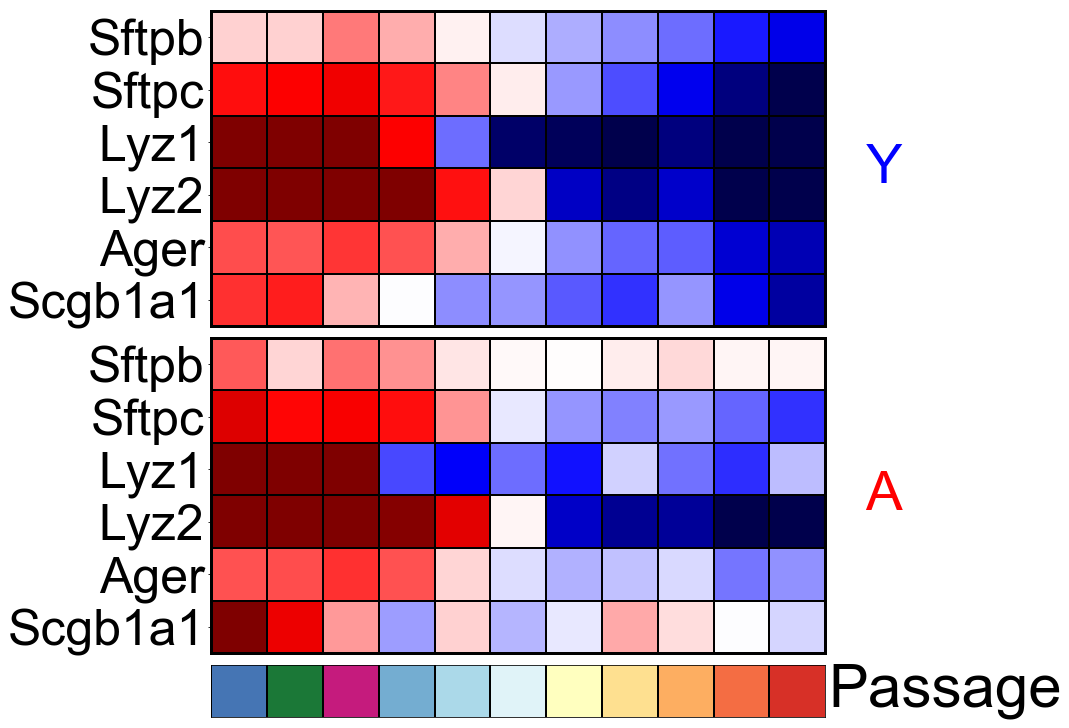

In [38]:
features = ['Sftpb','Sftpc','Lyz1','Lyz2','Ager','Scgb1a1']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)

#rearrange data

ixs = []
for a in ['Y','A']:
    for f in features:
        ixs.append('%s_%s'%(f,a))
dat2 = pd.DataFrame(index = ixs,
                    columns = ['AT2','Alv_Org','P0_Cre','P1','P2','P3','P4','P5','P6','P7','P8'])
for gr in dat2.columns:
    for a in ['Y','A']:
        for f in features:
            dat2.loc['%s_%s'%(f,a)][gr] = dat.loc[f]['%s_%s'%(gr,a)]
    
#initialize figure

height = 1 * len(dat2.index)+1
width = 1 * len(dat2.columns)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(3, 1, hspace=0.05, height_ratios=[len(features), len(features),1])
    
#plot data - young 

ax = plt.subplot(gs[0])

ax.set_xticks([])

ixs = ['%s_Y' % i for i in features]
ax.imshow(dat2.loc[ixs].astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 50, family = 'Arial')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
#plot age labels

ax.text(len(dat2.columns)*1.05, len(features)/2-0.5, 'Y', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='blue')

#plot data - aged

ax = plt.subplot(gs[1])

ax.set_xticks([])

ixs = ['%s_A' % i for i in features]
ax.imshow(dat2.loc[ixs].astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 50, family = 'Arial')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
#plot age labels

ax.text(len(dat2.columns)*1.05, len(features)/2-0.5, 'A', family = 'Arial', fontsize=55, rotation='horizontal', va = 'center', ha='center', color='red')

#passage
            
ax = plt.subplot(gs[2])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color=cmap_conditions['_'.join(p.split('_')[:-1])])
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 2, color = 'k')
    
ax.set_xticks([])
ax.set_yticks([])
    
ax.text(len(groups)*1.005, 0.5, 'Passage', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')
    
figname = 'invitro_heatmap3.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

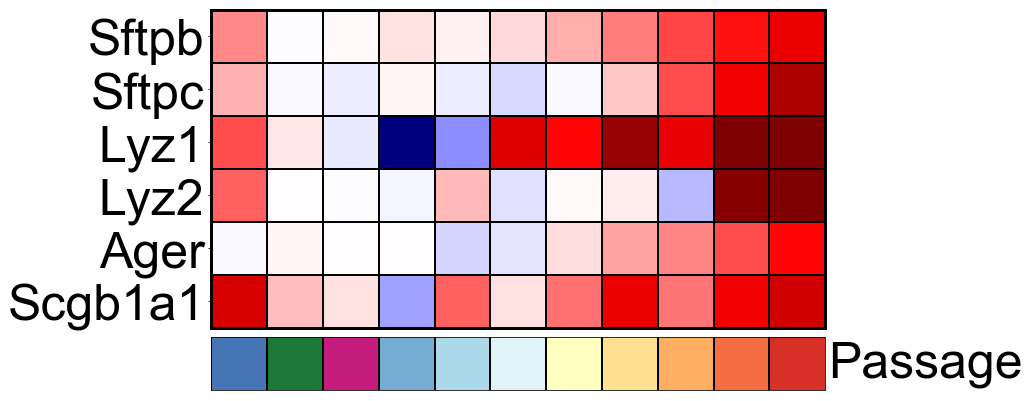

In [48]:
features = ['Sftpb','Sftpc','Lyz1','Lyz2','Ager','Scgb1a1']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat+1)

#calculate fold change between aged and young

dat_fc = pd.DataFrame(index=features, columns=['AT2','Alv_Org','P0_Cre','P1','P2','P3','P4','P5','P6','P7','P8'])
for f in features:
    for c in dat_fc.columns:
        dat_fc.loc[f,c] = dat.loc[f]['%s_Y'%c] - dat.loc[f]['%s_A'%c]
   
#initialize figure

height = 1 * len(dat_fc.index)+1
width = 1 * len(dat_fc.columns)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(2, 1, hspace=0.05, height_ratios=[len(dat_fc.index),1])
    
#plot data 

ax = plt.subplot(gs[0])

ax.set_xticks([])

ax.imshow(dat_fc.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic_r, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 50, family = 'Arial')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')

#passage
            
ax = plt.subplot(gs[1])
ax.set_xlim(0,len(dat_fc.columns))

for i,p in enumerate(dat_fc.columns):
    ax.axvspan(i,i+1, color=cmap_conditions[p])
    
for i in range(int(len(dat_fc.columns))):
    ax.axvline(i, linewidth = 2, color = 'k')
    
ax.set_xticks([])
ax.set_yticks([])
    
ax.text(len(dat_fc.columns)*1.005, 0.5, 'Passage', family = 'Arial', fontsize = 50, va = 'center', ha = 'left')
    
figname = 'invitro_heatmap_fc.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [41]:
dat_fc

,AT2,Alv_Org,P0_Cre,P1,P2,P3,P4,P5,P6,P7,P8
Sftpb,-0.232208,0.00729959,-0.0140801,-0.0563926,-0.0292406,-0.0778193,-0.163439,-0.254007,-0.36371,-0.463446,-0.572866
Sftpc,-0.155466,0.0103531,0.0326745,-0.0213859,0.0357443,0.0757086,0.00958181,-0.101825,-0.346151,-0.552583,-0.816264
Lyz1,-0.351264,-0.0494406,0.0406173,0.856062,0.220502,-0.630659,-0.491136,-0.902346,-0.580539,-1.62923,-1.70951
Lyz2,-0.310901,-0.00124042,0.000954297,0.0188587,-0.138353,0.057426,-0.0130396,-0.0378373,0.139158,-0.967027,-1.29492
Ager,0.0111888,-0.0182995,-0.00426934,-0.0026332,0.0790079,0.0489246,-0.0674184,-0.181369,-0.241476,-0.351413,-0.490066
Scgb1a1,-0.654506,-0.125082,-0.0586752,0.187077,-0.30863,-0.0592993,-0.280217,-0.573495,-0.27227,-0.550577,-0.677218


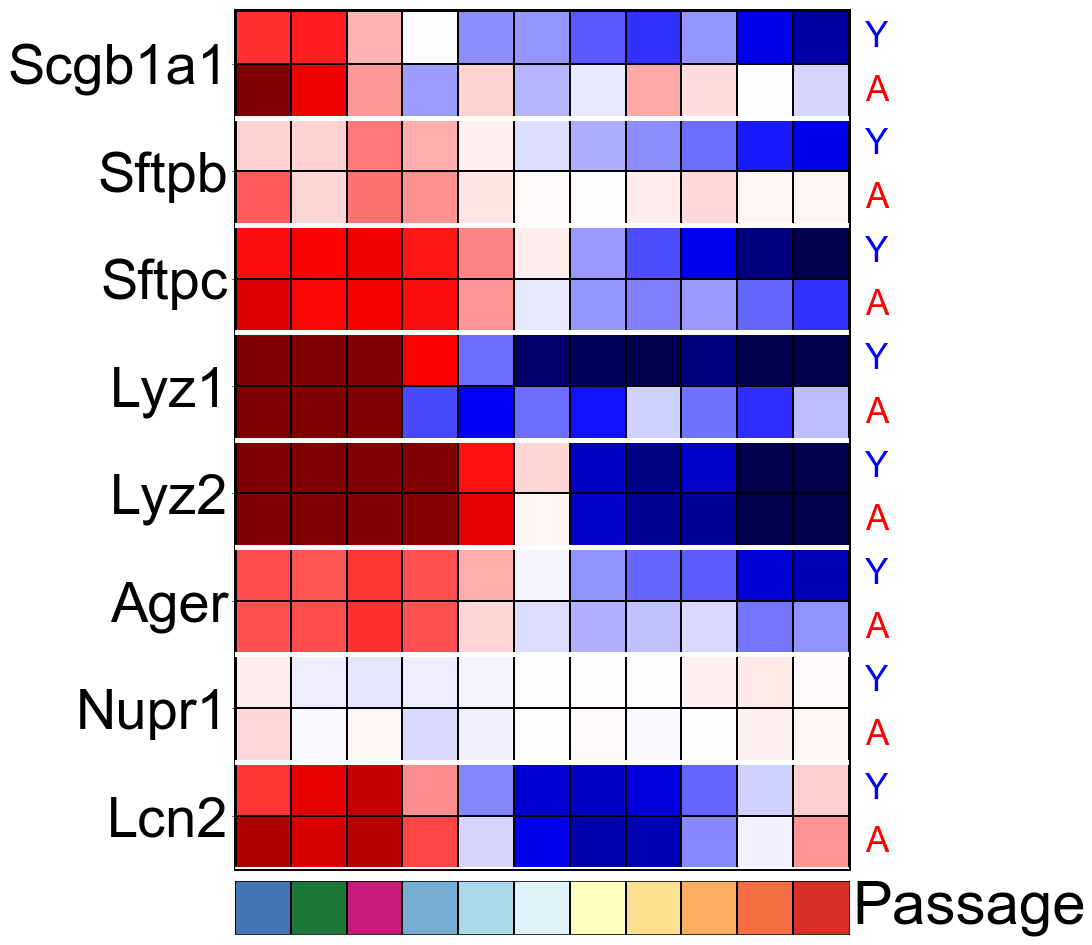

In [112]:
features = ['Scgb1a1','Sftpb','Sftpc','Lyz1','Lyz2','Ager','Nupr1','Lcn2']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)

#rearrange data

ixs = []
for f in features:
    for a in ['Y','A']:
        ixs.append('%s_%s'%(f,a))
dat2 = pd.DataFrame(index = ixs,
                    columns = ['AT2','Alv_Org','P0_Cre','P1','P2','P3','P4','P5','P6','P7','P8'])
for gr in dat2.columns:
    for a in ['Y','A']:
        for f in features:
            dat2.loc['%s_%s'%(f,a)][gr] = dat.loc[f]['%s_%s'%(gr,a)]
    
#initialize figure

height = 1 * len(dat2.index)+1
width = 1 * len(dat2.columns)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(2, 1, hspace=0.025, height_ratios=[len(dat2.index),1])

ax = plt.subplot(gs[0])

ax.set_xticks([])
    
#plot data 

ax.imshow(dat2.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks([i * 2 + 0.5 for i in range(len(features))])
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 56, family = 'Arial')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(dat2.index)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')
    if y%2:
        ax.axhline(y+0.5, linewidth = 5, color = 'w', zorder=3)

for x in range(len(dat2.columns)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
#plot age labels

for i in range(len(dat2.index)):
    if i%2:
        ax.text(len(dat2.columns), i, 'A', family = 'Arial', fontsize=35, rotation='horizontal', va = 'center', ha='center', color='red')
    else:
        ax.text(len(dat2.columns), i, 'Y', family = 'Arial', fontsize=35, rotation='horizontal', va = 'center', ha='center', color='blue')


#passage
            
ax = plt.subplot(gs[1])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color=cmap_conditions['_'.join(p.split('_')[:-1])])
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 2, color = 'k')
    
ax.set_xticks([])
ax.set_yticks([])
    
ax.text(len(groups)*1.005, 0.5, 'Passage', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')
    
figname = 'invitro_heatmap2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [99]:
len(dat.index)

8

In [78]:
dat2

,,,,,,,,AT2,Alv_Org,P0_Cre,P1,P2,P3,P4,P5,P6,P7,P8
Scgb1a1_Y,Sftpb_Y,Sftpc_Y,Lyz1_Y,Lyz2_Y,Ager_Y,Nupr1_Y,Lcn2_Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scgb1a1_A,Sftpb_A,Sftpc_A,Lyz1_A,Lyz2_A,Ager_A,Nupr1_A,Lcn2_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


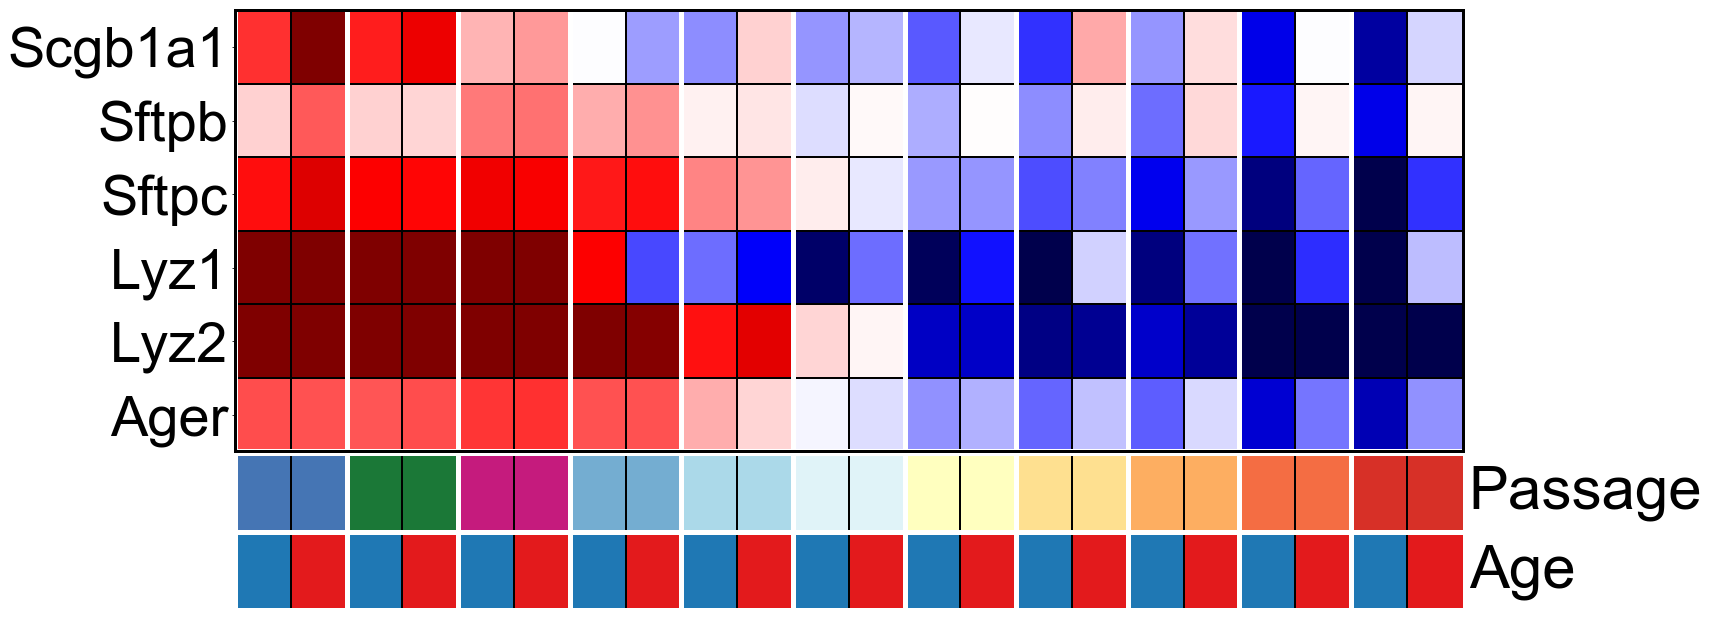

In [22]:
features = ['Scgb1a1','Sftpb','Sftpc','Lyz1','Lyz2','Ager']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)+5
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(3, 1, hspace=0.025, height_ratios=[len(features),1,1])

ax = plt.subplot(gs[0])
    
#plot data

ax.imshow(dat.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 56, family = 'Arial')

#plot group names

ax.set_xticks([])
#ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2 - 0.5, linewidth = 5, color = 'w')
    
ax.axhline(5+0.5, linewidth = 5, color = 'w')

#passage
            
ax = plt.subplot(gs[1])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color=cmap_conditions['_'.join(p.split('_')[:-1])])
    ax.axvline(i, linewidth = 2, color = 'k')
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 5, color = 'w')
    
clean_axis(ax)

ax.text(len(groups)*1.005, 0.5, 'Passage', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')

#age

ax = plt.subplot(gs[2])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color={'Y':'#1f78b4','A':'#e31a1c'}['_'.join(p.split('_')[-1])])
    ax.axvline(i, linewidth = 2, color = 'k')
    
clean_axis(ax)

ax.text(len(groups)*1.005, 0.5, 'Age', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')

for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 5, color = 'w')
    
figname = 'invitro_heatmap.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

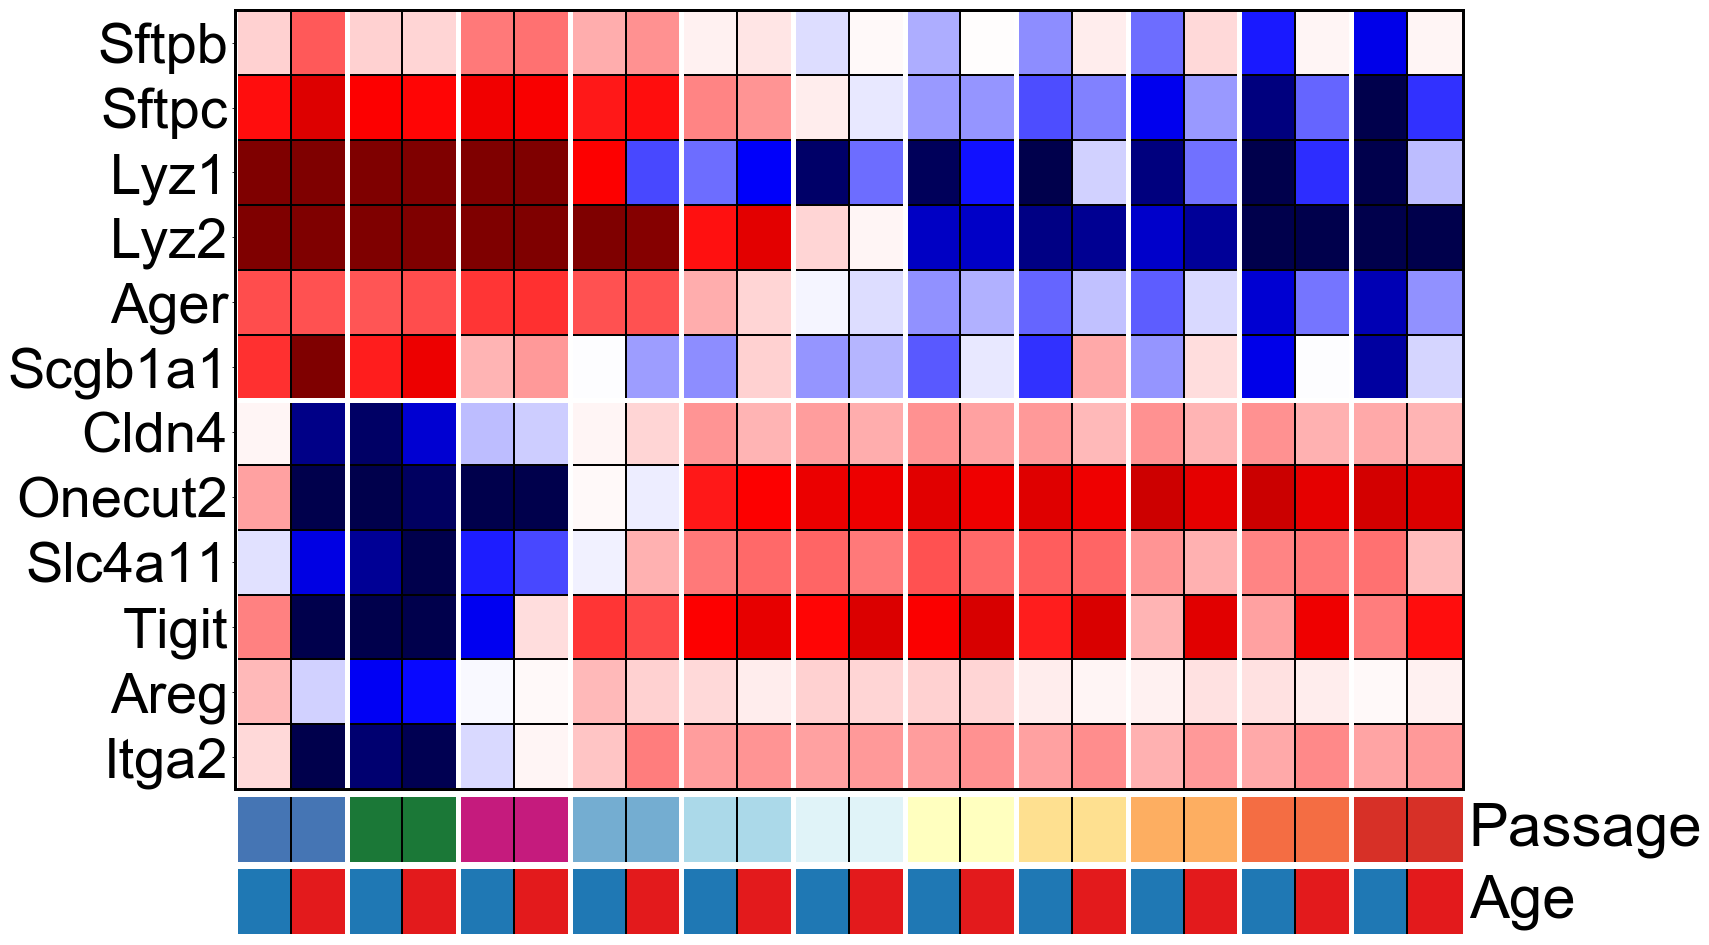

In [322]:
features = ['Sftpb','Sftpc','Lyz1','Lyz2','Ager','Scgb1a1',
            'Cldn4','Onecut2','Slc4a11','Tigit','Areg','Itga2']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)+5
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(3, 1, hspace=0.025, height_ratios=[len(features),1,1])

ax = plt.subplot(gs[0])
    
#plot data

ax.imshow(dat.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 56, family = 'Arial')

#plot group names

ax.set_xticks([])
#ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2 - 0.5, linewidth = 5, color = 'w')
    
ax.axhline(5+0.5, linewidth = 5, color = 'w')

#passage
            
ax = plt.subplot(gs[1])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color=cmap_conditions['_'.join(p.split('_')[:-1])])
    ax.axvline(i, linewidth = 2, color = 'k')
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 5, color = 'w')
    
clean_axis(ax)

ax.text(len(groups)*1.005, 0.5, 'Passage', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')

#age

ax = plt.subplot(gs[2])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color={'Y':'#1f78b4','A':'#e31a1c'}['_'.join(p.split('_')[-1])])
    ax.axvline(i, linewidth = 2, color = 'k')
    
clean_axis(ax)

ax.text(len(groups)*1.005, 0.5, 'Age', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')

for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 5, color = 'w')
    
figname = 'invitro_heatmap.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

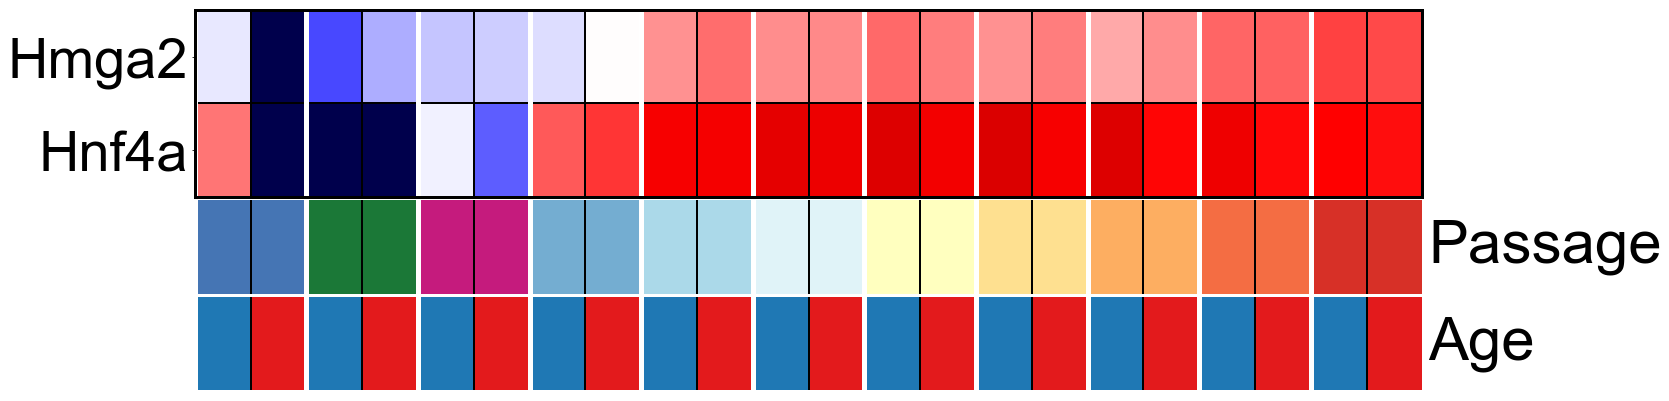

In [34]:
features = ['Hmga2','Hnf4a']
groups = Xs_comb.columns
dat = Xs_comb.loc[features, groups]
dat = np.log2(dat.loc[features].astype(float)+1)
dat = dat.apply(lambda x: x - x.mean(), axis=1)
    
#initialize figure

height = 1 * len(features)+5
width = 1 * len(groups)

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(3, 1, hspace=0.025, height_ratios=[len(features),1,1])

ax = plt.subplot(gs[0])
    
#plot data

ax.imshow(dat.astype(float), vmin = -1, vmax = 1, cmap = plt.cm.seismic, aspect = 'auto')

# plot gene names

ax.set_yticks(range(len(features)))
ax.set_yticklabels([i.split('_')[0] for i in features], fontsize = 56, family = 'Arial')

#plot group names

ax.set_xticks([])
#ax.set_xticklabels([i for i in groups], fontsize = 25, family = 'Arial', rotation = 'vertical')
ax.xaxis.set_ticks_position('top')

# plot grid

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
    
for y in range(len(features)):
    ax.axhline(y+0.5, linewidth = 2, color = 'k')

for x in range(len(groups)):
    ax.axvline(x+0.5, linewidth = 2, color = 'k')
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2 - 0.5, linewidth = 5, color = 'w')
    
#ax.axhline(5+0.5, linewidth = 5, color = 'w')

#passage
            
ax = plt.subplot(gs[1])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color=cmap_conditions['_'.join(p.split('_')[:-1])])
    ax.axvline(i, linewidth = 2, color = 'k')
    
for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 5, color = 'w')
    
clean_axis(ax)

ax.text(len(groups)*1.005, 0.5, 'Passage', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')

#age

ax = plt.subplot(gs[2])
ax.set_xlim(0,len(groups))

for i,p in enumerate(groups):
    ax.axvspan(i,i+1, color={'Y':'#1f78b4','A':'#e31a1c'}['_'.join(p.split('_')[-1])])
    ax.axvline(i, linewidth = 2, color = 'k')
    
clean_axis(ax)

ax.text(len(groups)*1.005, 0.5, 'Age', family = 'Arial', fontsize = 60, va = 'center', ha = 'left')

for i in range(int(len(groups)/2)):
    ax.axvline(i * 2, linewidth = 5, color = 'w')

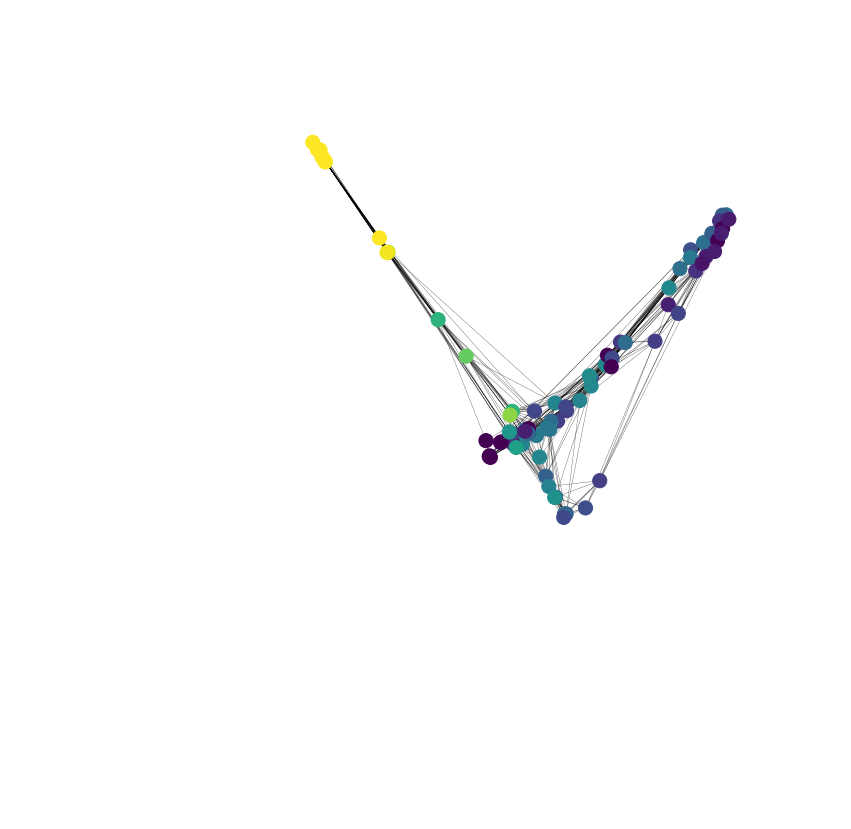

In [280]:
dat = scX
coords = dat.obsm['X_diffmap'][:,1:]
expr = X_pop.loc['AT2', scX.obs_names]
vmin = np.percentile(expr,10)
vmax = np.percentile(expr,90)


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[plt.cm.viridis((i-vmin)/(vmax-vmin)) for i in expr],
           alpha=1,
           s = 200)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

conn = dat.obsp['connectivities'].todense()
for p,q in itertools.combinations(range(len(dat.obs_names)),2):
    if conn[p,q]:
        ax.plot(coords[(p,q),0], coords[(p,q),1], coords[(p,q),2], c='k', lw=0.25)
        
ax.set_axis_off()
        
figname = 'invitro_scatter_AT2.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

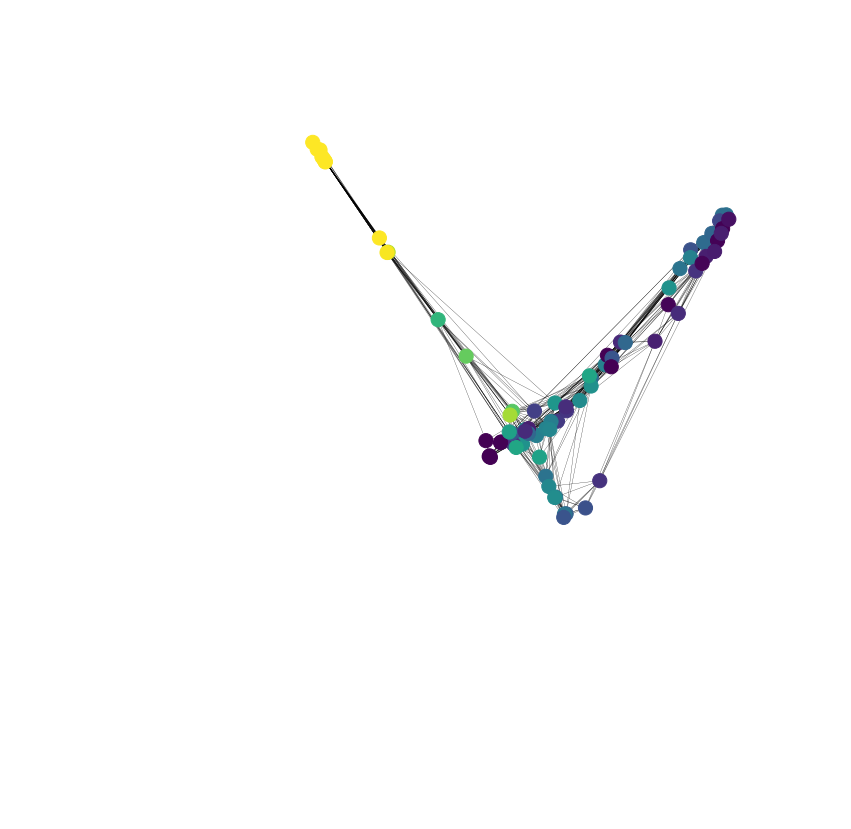

In [281]:
dat = scX
coords = dat.obsm['X_diffmap'][:,1:]
expr = X_pop.loc['AT2-like', scX.obs_names]
vmin = np.percentile(expr,10)
vmax = np.percentile(expr,90)


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[plt.cm.viridis((i-vmin)/(vmax-vmin)) for i in expr],
           alpha=1,
           s = 200)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

conn = dat.obsp['connectivities'].todense()
for p,q in itertools.combinations(range(len(dat.obs_names)),2):
    if conn[p,q]:
        ax.plot(coords[(p,q),0], coords[(p,q),1], coords[(p,q),2], c='k', lw=0.25)
        
ax.set_axis_off()
        
figname = 'invitro_scatter_AT2-like.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

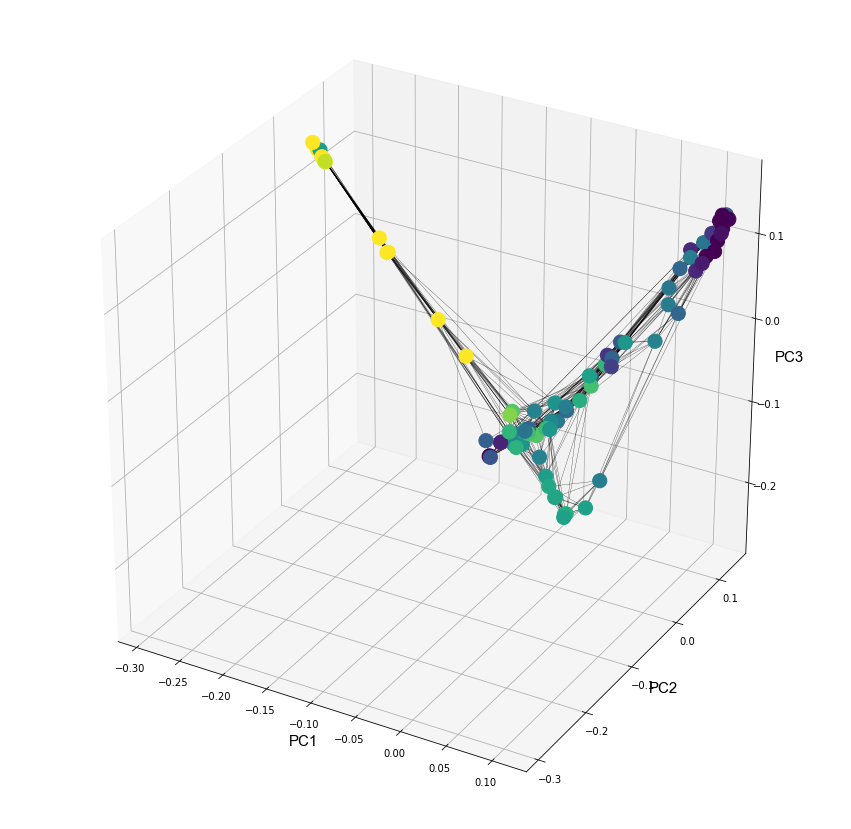

In [268]:
dat = scX
coords = dat.obsm['X_diffmap'][:,1:]
expr = X_pop.loc['AT1-like', scX.obs_names]
vmin = np.percentile(expr,10)
vmax = np.percentile(expr,90)


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[plt.cm.viridis((i-vmin)/(vmax-vmin)) for i in expr],
           alpha=1,
           s = 200)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

conn = dat.obsp['connectivities'].todense()
for p,q in itertools.combinations(range(len(dat.obs_names)),2):
    if conn[p,q]:
        ax.plot(coords[(p,q),0], coords[(p,q),1], coords[(p,q),2], c='k', lw=0.25)

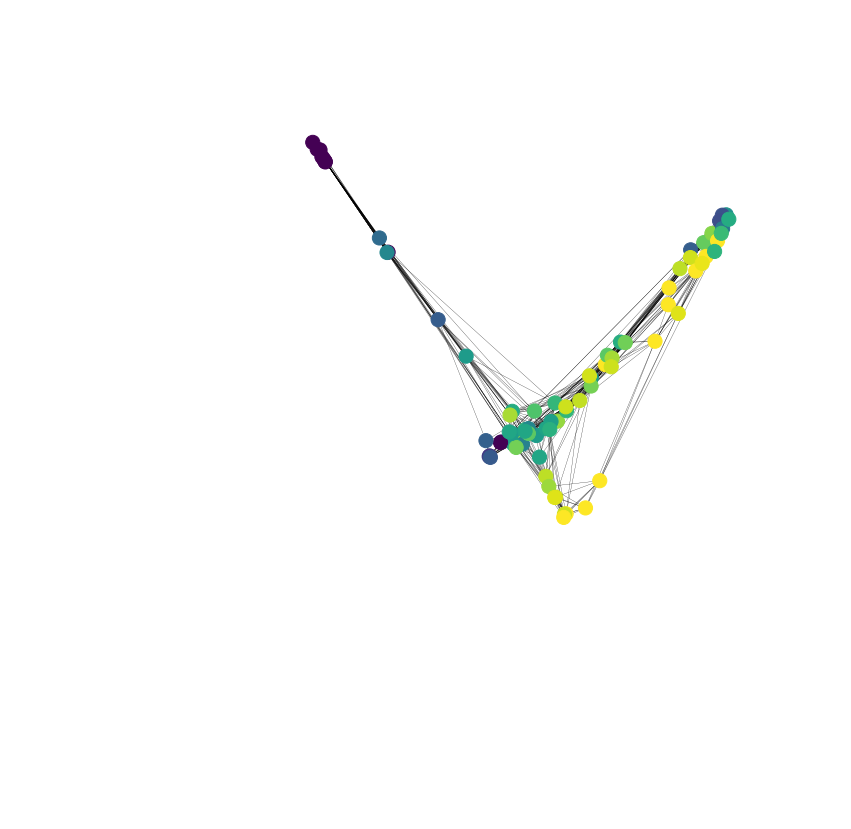

In [282]:
dat = scX
coords = dat.obsm['X_diffmap'][:,1:]
expr = X_pop.loc['High plasticity cell state', scX.obs_names]
vmin = np.percentile(expr,10)
vmax = np.percentile(expr,90)


height = 15
width = 15

fig = plt.figure(facecolor = 'w', figsize = (width, height))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(coords[:,0].min() * 1.1, coords[:,0].max() * 1.1)
ax.set_ylim3d(coords[:,1].min() * 1.1, coords[:,1].max() * 1.1)
ax.set_zlim3d(coords[:,2].min() * 1.1, coords[:,2].max() * 1.1)

ax.scatter(coords[:,0], 
           coords[:,1], 
           coords[:,2], 
           c=[plt.cm.viridis((i-vmin)/(vmax-vmin)) for i in expr],
           alpha=1,
           s = 200)
    

ax.set_xlabel('PC1', family = 'Arial', fontsize = 15)
ax.set_ylabel('PC2', family = 'Arial', fontsize = 15)
ax.set_zlabel('PC3', family = 'Arial', fontsize = 15)

conn = dat.obsp['connectivities'].todense()
for p,q in itertools.combinations(range(len(dat.obs_names)),2):
    if conn[p,q]:
        ax.plot(coords[(p,q),0], coords[(p,q),1], coords[(p,q),2], c='k', lw=0.25)
        
ax.set_axis_off()
        
figname = 'invitro_scatter_HPCS.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)